In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from lcls_beamline_toolbox.xraybeamline2d import beam as beam, optics as optics, beamline2d as beamline

Can't find epics package. PPM_Imager class will not be supported


## LCLS-II-HE parameter definitions

## To do list
Incorporate parameters from LCLS-II-HE Undulator Performance document. \
Fit 7 to 14 keV separately from 15 to 18 keV, since they changed the quadrupole settings at that point. \
Can just linearly interpolate between 14 and 15 keV for now. \
Mirror length 600mm \
Working distance 750mm \
Also simulate 30 um case, with focus upstream.

In [2]:
file_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'
df = pd.read_csv(file_path+'HXR_100pC_distilled.csv')
#print(df['Photon energy (keV)'])

# generic function for curve_fit
def generic_curve(x,a,b,c):
    
    return a*x**b + c

energy = np.array(df['Photon energy'])
z_source = np.array(df['z_source'])
div_x = np.array(df['div_x'])
div_y = np.array(df['div_y'])
sigma_x = np.array(df['sigma_x'])
sigma_y = np.array(df['sigma_y'])
div_x_rms = np.array(df['div_x_rms'])
div_y_rms = np.array(df['div_y_rms'])

def generate_fit(data, quantity):
    
    energy = np.array(df['Photon energy'])
    source_quantity = np.array(df[quantity])
    
#     popt1, pcov1 = curve_fit(generic_curve, energy[0:9], z_source[0:9], method='trf')
#     popt1, pcov1 = curve_fit(generic_curve, energy[0:9], z_source[0:9], p0=[1,1,np.mean(z_source[0:9])])
    p1 = np.polyfit(energy[:9], source_quantity[:9], 3)
    p2 = np.polyfit(energy[9:], source_quantity[9:], 2)
#     popt2, pcov2 = curve_fit(generic_curve, energy[9:], z_source[9:])
#     popt1 = list(popt1)
#     print(*popt1)
    
    def fit_function(E0):
        
        E0 = np.array(E0)
        out = np.zeros_like(E0)
        
        mask1 = E0<=14
#         mask2 = np.logical_not(mask1)
        mask2 = E0>=15
    
        mask3 = np.logical_not(np.logical_or(mask1,mask2))
        
#         out[mask1] = generic_curve(E0[mask1], *popt1)
        out[mask1] = np.polyval(p1, E0[mask1])
#         out[mask2] = np.interp(E0[mask2], energy, z_source)
        out[mask2] = np.polyval(p2, E0[mask2])
        out[mask3] = np.interp(E0[mask3], energy, source_quantity)
        
        return out
#         if energy<=14:
#             return generic_curve(E0, *popt1)
#         else:
#             source_z = np.interp(E0, energy, z_source)
#             return source_z
    
    return fit_function

In [3]:
test = 1

In [4]:
bool_test = test is not None

In [5]:
bool_test

True

In [6]:
source_z_fit = generate_fit(df, 'z_source')
div_x_fit = generate_fit(df, 'div_x')
div_y_fit = generate_fit(df, 'div_y')
sigma_x_fit = generate_fit(df, 'sigma_x')
sigma_y_fit = generate_fit(df, 'sigma_y')
div_x_rms_fit = generate_fit(df, 'div_x_rms')
div_y_rms_fit = generate_fit(df, 'div_y_rms')

<IPython.core.display.Javascript object>


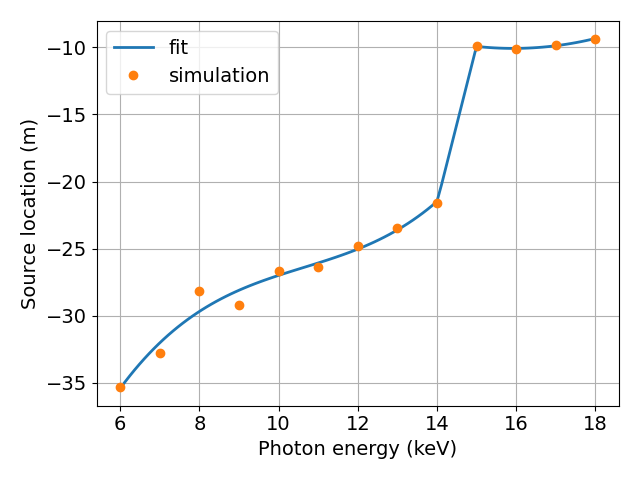

<IPython.core.display.Javascript object>


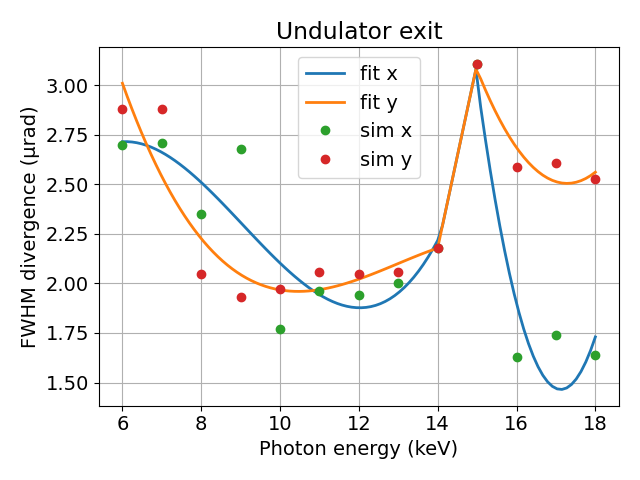

<IPython.core.display.Javascript object>


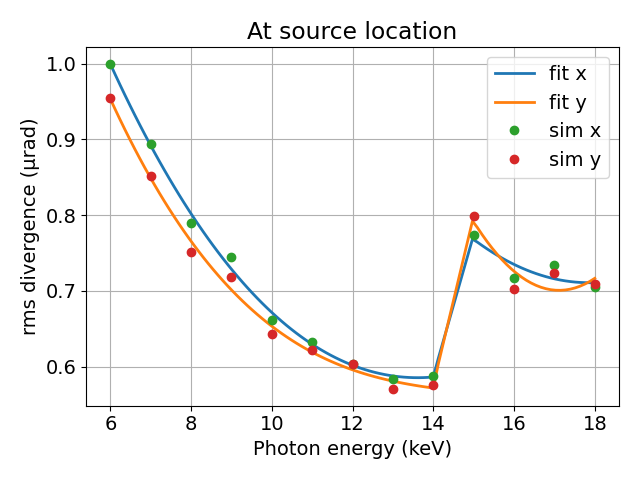

<IPython.core.display.Javascript object>


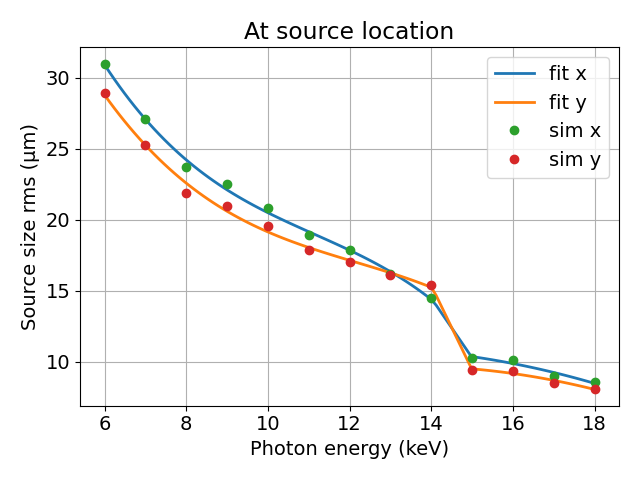

<IPython.core.display.Javascript object>


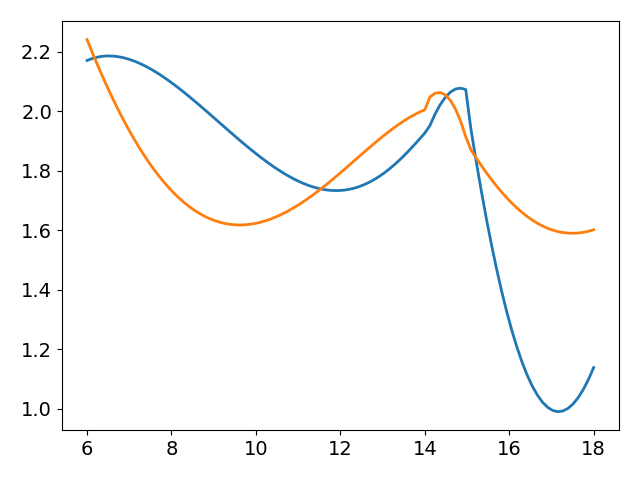

<IPython.core.display.Javascript object>


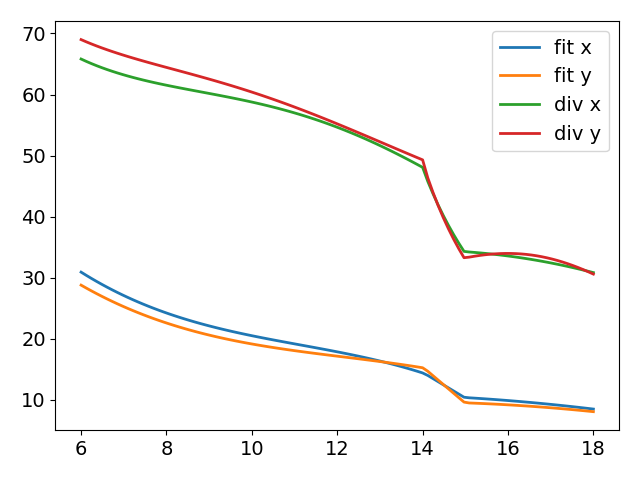

In [7]:
fig_path = file_path + 'figures/'

e_interp = np.linspace(np.min(energy),np.max(energy),100)

# calculate divergence
# divergence_x = self.wavelength / np.pi / self.sigma_x
# divergence_y = self.wavelength / np.pi / self.sigma_y

wavelength = 1239.8/(energy*1000)*1e-9
w_interp = 1239.8/(e_interp*1000)*1e-9

plt.figure()
plt.plot(e_interp, source_z_fit(e_interp),label='fit')
plt.plot(energy, z_source,'o',label='simulation')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('Source location (m)')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path+'source_z.png')

plt.figure()
plt.plot(e_interp, div_x_fit(e_interp),label='fit x')
plt.plot(e_interp, div_y_fit(e_interp),label='fit y')
plt.plot(energy, div_x,'o',label='sim x')
plt.plot(energy, div_y,'o',label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('FWHM divergence (\u03BCrad)')
plt.legend()
plt.title('Undulator exit')
plt.tight_layout()
plt.savefig(fig_path+'exit_div_fwhm.png')


plt.figure()
plt.plot(e_interp, div_x_rms_fit(e_interp),label='fit x')
plt.plot(e_interp, div_y_rms_fit(e_interp),label='fit y')
plt.plot(energy, div_x_rms,'o',label='sim x')
plt.plot(energy, div_y_rms,'o',label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('rms divergence (\u03BCrad)')
plt.title('At source location')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path+'source_div_rms.png')

plt.figure()
plt.plot(e_interp, sigma_x_fit(e_interp),label='fit x')
plt.plot(e_interp, sigma_y_fit(e_interp),label='fit y')
plt.plot(energy, sigma_x, 'o', label='sim x')
plt.plot(energy, sigma_y, 'o', label='sim y')
plt.grid()
plt.xlabel('Photon energy (keV)')
plt.ylabel('Source size rms (\u03BCm)')
plt.title('At source location')
plt.legend()
plt.tight_layout()
plt.savefig(fig_path + 'source_size_rms.png')

sig_div_x = w_interp/np.pi/(div_x_rms_fit(e_interp)*1e-6)*1e6
sig_div_y = w_interp/np.pi/(div_y_rms_fit(e_interp)*1e-6)*1e6



M2x = div_x_fit(e_interp)*.85*2*sigma_x_fit(e_interp)/w_interp*(np.pi)*1e-12
M2y = div_y_fit(e_interp)*.85*2*sigma_y_fit(e_interp)/w_interp*(np.pi)*1e-12

plt.figure()
plt.plot(e_interp, M2x)
plt.plot(e_interp, M2y)

plt.figure()
plt.plot(e_interp, sigma_x_fit(e_interp),label='fit x')
plt.plot(e_interp, sigma_y_fit(e_interp),label='fit y')
plt.plot(e_interp, w_interp/np.pi/(div_x_rms_fit(e_interp)*1e-6)*1e6,label='div x')
plt.plot(e_interp, w_interp/np.pi/(div_y_rms_fit(e_interp)*1e-6)*1e6,label='div y')
plt.legend()


# plt.plot(e_interp, div_x_rms_fit(e_interp))
# plt.plot(energy, div_x_rms)

### Beam parameters

In [8]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 7000

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
# beam_params = {
#     'photonEnergy': E0,
#     'N': N,
#     'sigma_x': 27e-6,
#     'sigma_y': 27e-6,
#     'rangeFactor': 5,
#     'scaleFactor': 10,
#     'z0x': 105.6817,
#     'z0y': 106.6817,
#     'z_source': 650-32.8
# }
zs = 650+source_z_fit(E0/1000)
im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

z0 = im2l0.z-zs

beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': sigma_x_fit(E0/1000)*1e-6/1.1,
    'sigma_y': sigma_y_fit(E0/1000)*1e-6/1.1,
#     'rangeFactor': 5,
#     'scaleFactor': 10,
#     'z0x': z0,
#     'z0y': z0
    'z_source': zs
}

### Define beamline

In [9]:

# initialize the beam
b1 = beam.Beam(beam_params=beam_params)

# pf1l0 = optics.WFS('pf1l0', pitch=15e-6, duty_cycle=1, phase=True, z=735.6817)
# im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

DG1 = optics.PPM('Upstream', FOV=2e-3, z=1029.5)
hfm = optics.CurvedMirror('hfm', length=.35, p=440, q=0.9, alpha=3.052e-3, z=1030.1-125e-6, orientation=0,delta=0e-6)
vfm = optics.CurvedMirror('vfm', length=.35, p=440, q=0.5, alpha=2.742e-3, z=1030.5-40e-6, orientation=1)
DG2 = optics.PPM('Downstream', FOV=1e-3, z=1030.6)

IP = optics.PPM('IP', FOV=1.0e-6, z=1030.5+.5)

# list of devices to propagate through
devices = [DG1, hfm, vfm, DG2, IP]

# initialize beamline
L_beamline = beamline.Beamline(devices)

FWHM in x: 41.07876134114969 microns
FWHM in y: 38.31279856199589 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
x is focused
y is focused


FWHM in x: 1112.5472919893687 microns
FWHM in y: 1192.767847158369 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
Upstream


/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


drift1
zRx: 309161517.53 microns
zRy: 268974150.91 microns
remaining distance: 599875.00 microns
goal for zx: 412133208.33 microns
current zx: 411533333.33 microns
goal for zy: 412133208.33 microns
current zy: 411533333.33 microns
hfm
drift2
zRx: 1471.86 microns
zRy: 268974150.91 microns
remaining distance: 400085.00 microns
goal for zx: -500039.49 microns
current zx: -900124.49 microns
goal for zy: 412533293.33 microns
current zy: 412133208.33 microns
vfm
drift3
zRx: 1471.86 microns
zRy: 394.41 microns
remaining distance: 100040.00 microns
goal for zx: -399999.49 microns
current zx: -500039.49 microns
goal for zy: -399997.83 microns
current zy: -500037.83 microns
Downstream
drift4
zRx: 1471.86 microns
zRy: 394.41 microns
remaining distance: 400000.00 microns
goal for zx: 0.51 microns
current zx: -399999.49 microns
goal for zy: 2.17 microns
current zy: -399997.83 microns
current step size: 398527.63 microns
x stays unfocused
y stays unfocused
zRx: 1471.86 microns
zRy: 394.41 microns
re

<IPython.core.display.Javascript object>


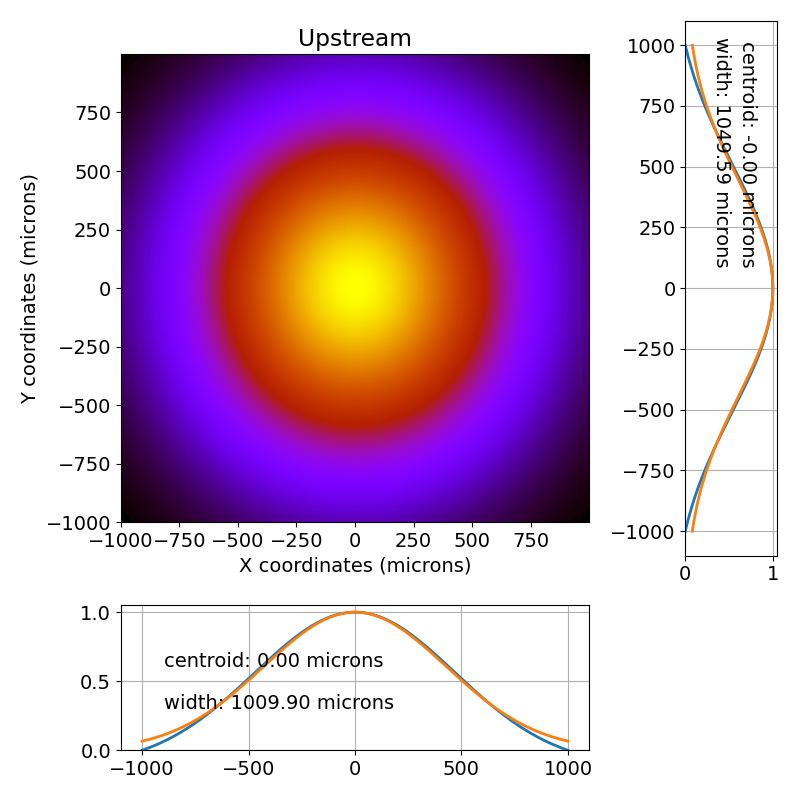

<IPython.core.display.Javascript object>


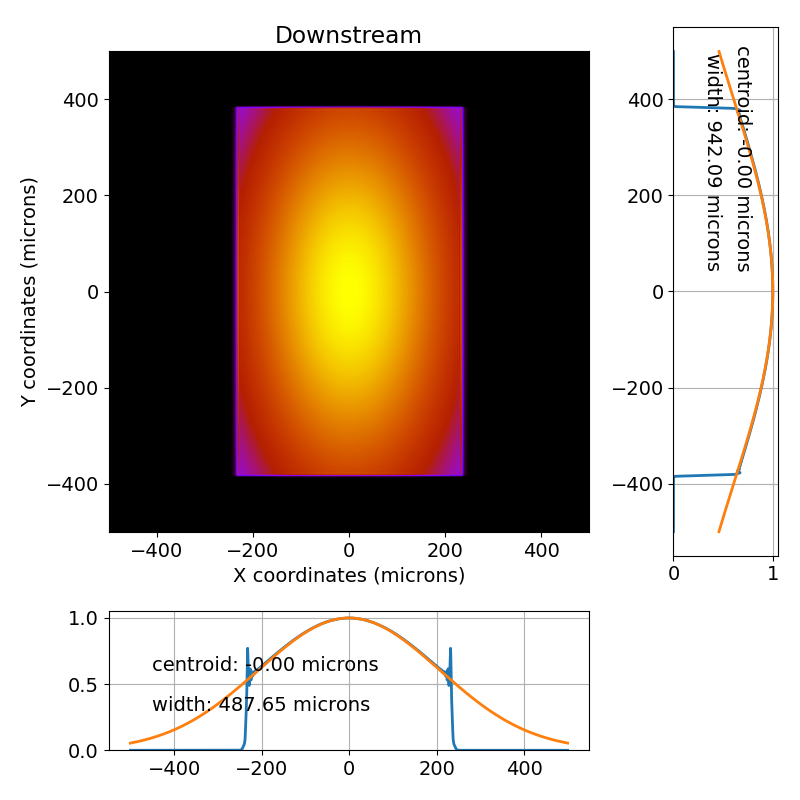

<IPython.core.display.Javascript object>


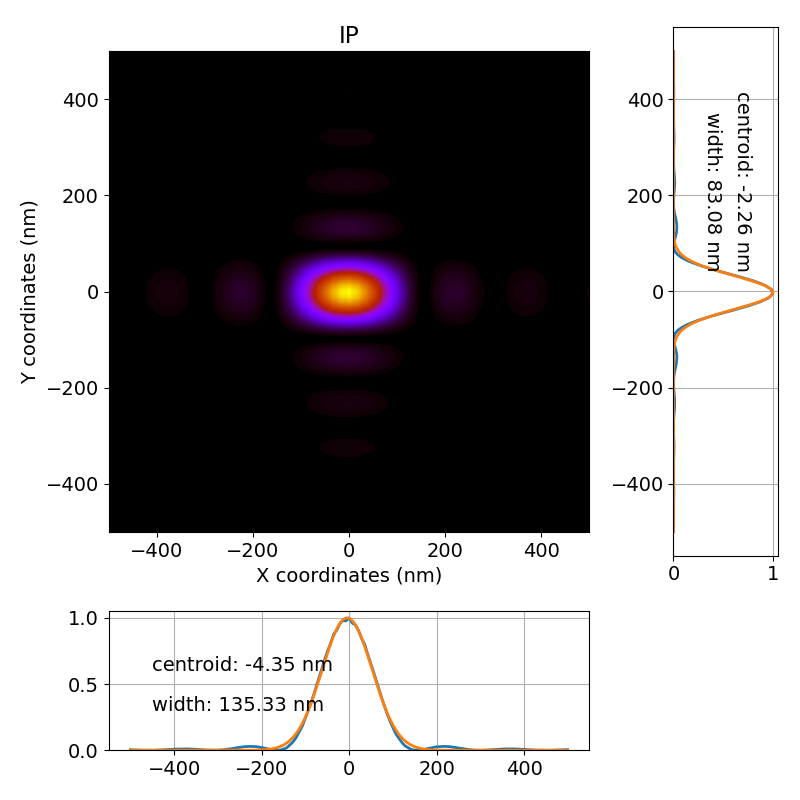

In [10]:
# propagate
b2 = L_beamline.propagate_beamline(b1)

fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/figures/'

L_beamline.Upstream.view_beam()
plt.savefig(fig_path+'upstream_KB01.png')
L_beamline.Downstream.view_beam()
plt.savefig(fig_path+'downstream_KB01.png')
L_beamline.IP.view_beam()
plt.savefig(fig_path+'IP_KB01.png')

In [11]:
L_beamline.IP.wy

8.307754038941143e-08

In [12]:

# initialize the beam
b1 = beam.Beam(beam_params=beam_params)

# pf1l0 = optics.WFS('pf1l0', pitch=15e-6, duty_cycle=1, phase=True, z=735.6817)
# im2l0 = optics.PPM('im2l0', FOV=2e-3, N=1024, z=736.508)

DG1 = optics.PPM('Upstream', FOV=5e-3, z=1029.5)
hfm = optics.CurvedMirror('hfm', length=.9, p=440, q=1.55-350e-6, alpha=3e-3, z=1029.75, orientation=0,delta=0e-6)
vfm = optics.CurvedMirror('vfm', length=.6, p=440, q=.8-100e-6, alpha=3e-3, z=1030.5, orientation=1)
DG2 = optics.PPM('Downstream', FOV=5e-3, z=1030.6)

IP = optics.PPM('IP', FOV=2e-6, z=1030.5+.8)

# list of devices to propagate through
devices = [DG1, hfm, vfm, DG2, IP]

# initialize beamline
L_beamline = beamline.Beamline(devices)

FWHM in x: 41.07876134114969 microns
FWHM in y: 38.31279856199589 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
x is focused
y is focused


### Propagation through monochromator at central photon energy

FWHM in x: 1112.5472919893687 microns
FWHM in y: 1192.767847158369 microns
FWHM Divergence (x): 2.7 μrad
FWHM Divergence (y): 2.9 μrad
Upstream


/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


drift1
zRx: 309161517.53 microns
zRy: 268974150.91 microns
remaining distance: 250000.00 microns
goal for zx: 411783333.33 microns
current zx: 411533333.33 microns
goal for zy: 411783333.33 microns
current zy: 411533333.33 microns
hfm
drift2
zRx: 4371.96 microns
zRy: 268974150.91 microns
remaining distance: 750000.00 microns
goal for zx: -800024.07 microns
current zx: -1550024.07 microns
goal for zy: 412533333.33 microns
current zy: 411783333.33 microns
vfm
drift3
zRx: 4371.96 microns
zRy: 1009.53 microns
remaining distance: 100000.00 microns
goal for zx: -700024.07 microns
current zx: -800024.07 microns
goal for zy: -699996.83 microns
current zy: -799996.83 microns
Downstream
drift4
zRx: 4371.96 microns
zRy: 1009.53 microns
remaining distance: 700000.00 microns
goal for zx: -24.07 microns
current zx: -700024.07 microns
goal for zy: 3.17 microns
current zy: -699996.83 microns
current step size: 695652.11 microns
x stays unfocused
y stays unfocused
zRx: 4371.96 microns
zRy: 1009.53 micr

<IPython.core.display.Javascript object>


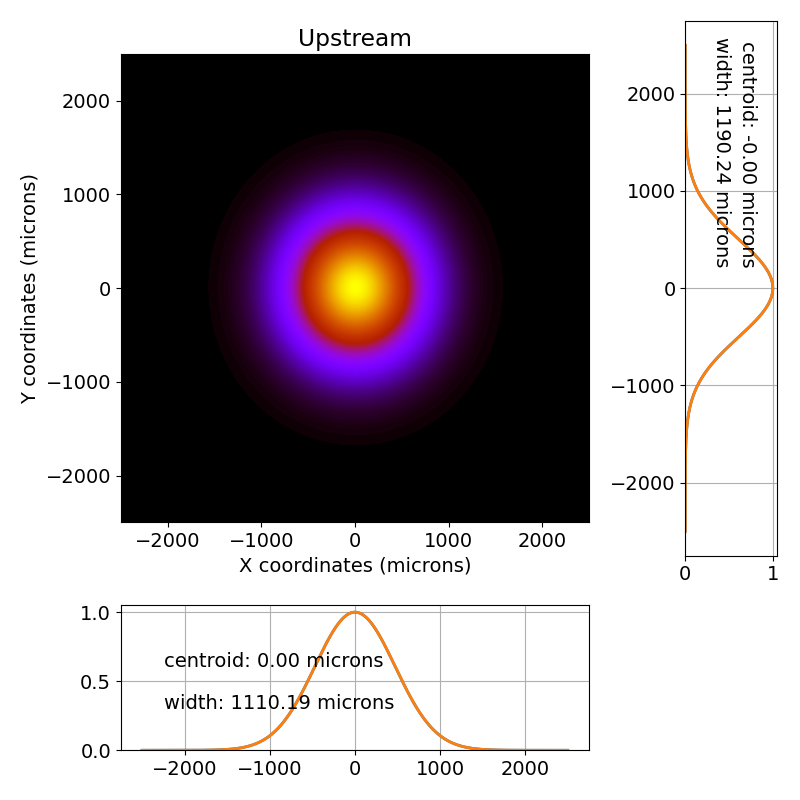

<IPython.core.display.Javascript object>


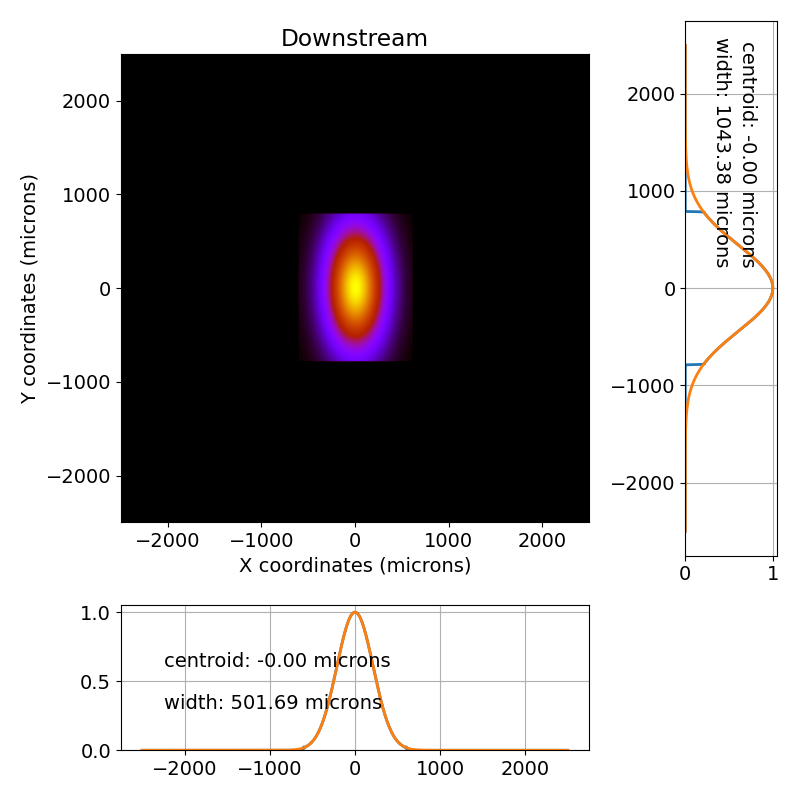

<IPython.core.display.Javascript object>


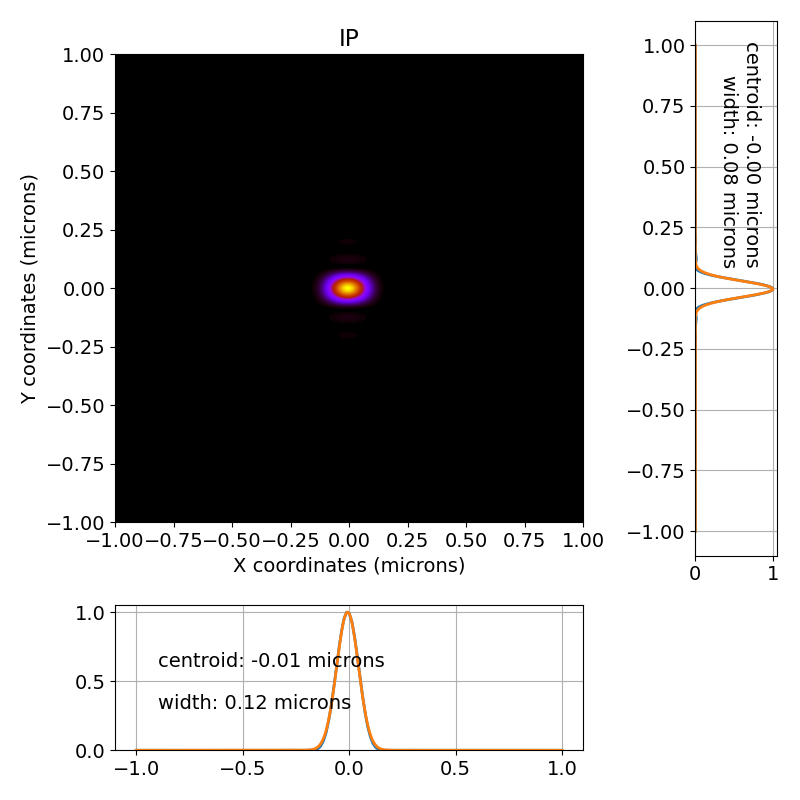

In [13]:
# propagate
b2 = L_beamline.propagate_beamline(b1)

fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'

L_beamline.Upstream.view_beam()
plt.savefig(fig_path+'upstream_100nm.png')
L_beamline.Downstream.view_beam()
plt.savefig(fig_path+'downstream_100nm.png')
L_beamline.IP.view_beam()
plt.savefig(fig_path+'IP_100nm.png')

In [33]:
L_beamline.IP.view_horizontal(ax=ax,show_fit=False,label='perfect',legend=True)

<IPython.core.display.Javascript object>


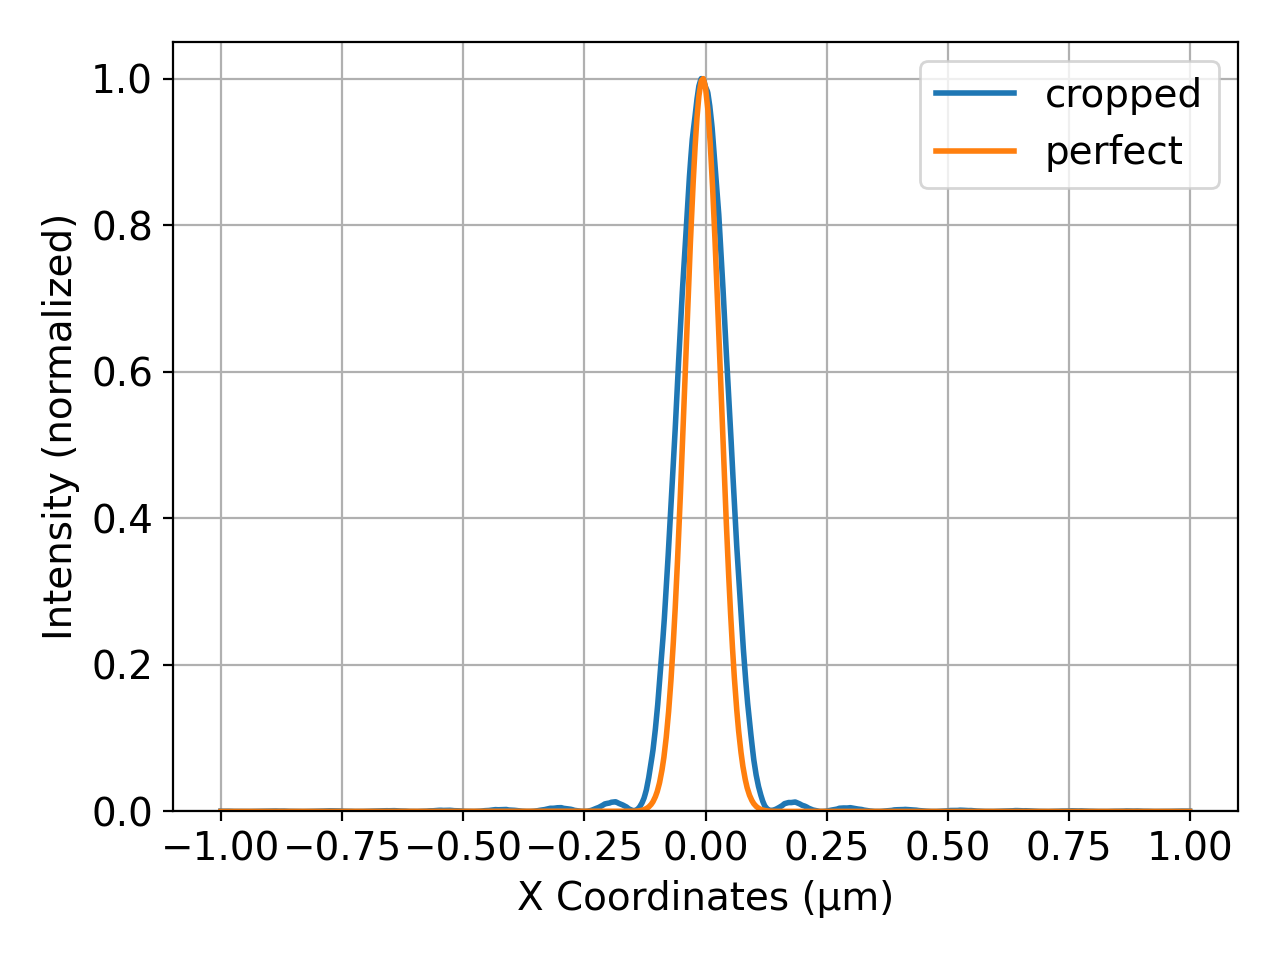

In [30]:
ax = L_beamline.IP.view_horizontal(show_fit=False,label='cropped')

In [26]:
ax.set_ylim(1e-8,1.1)

(1e-08, 1.1)

In [34]:
fig_path = '/Users/seaberg/OneDrive - SLAC National Accelerator Laboratory/Beam Delivery/CXI HE upgrade/'
plt.savefig(fig_path+'linear_comparison_100nm.png')

<IPython.core.display.Javascript object>


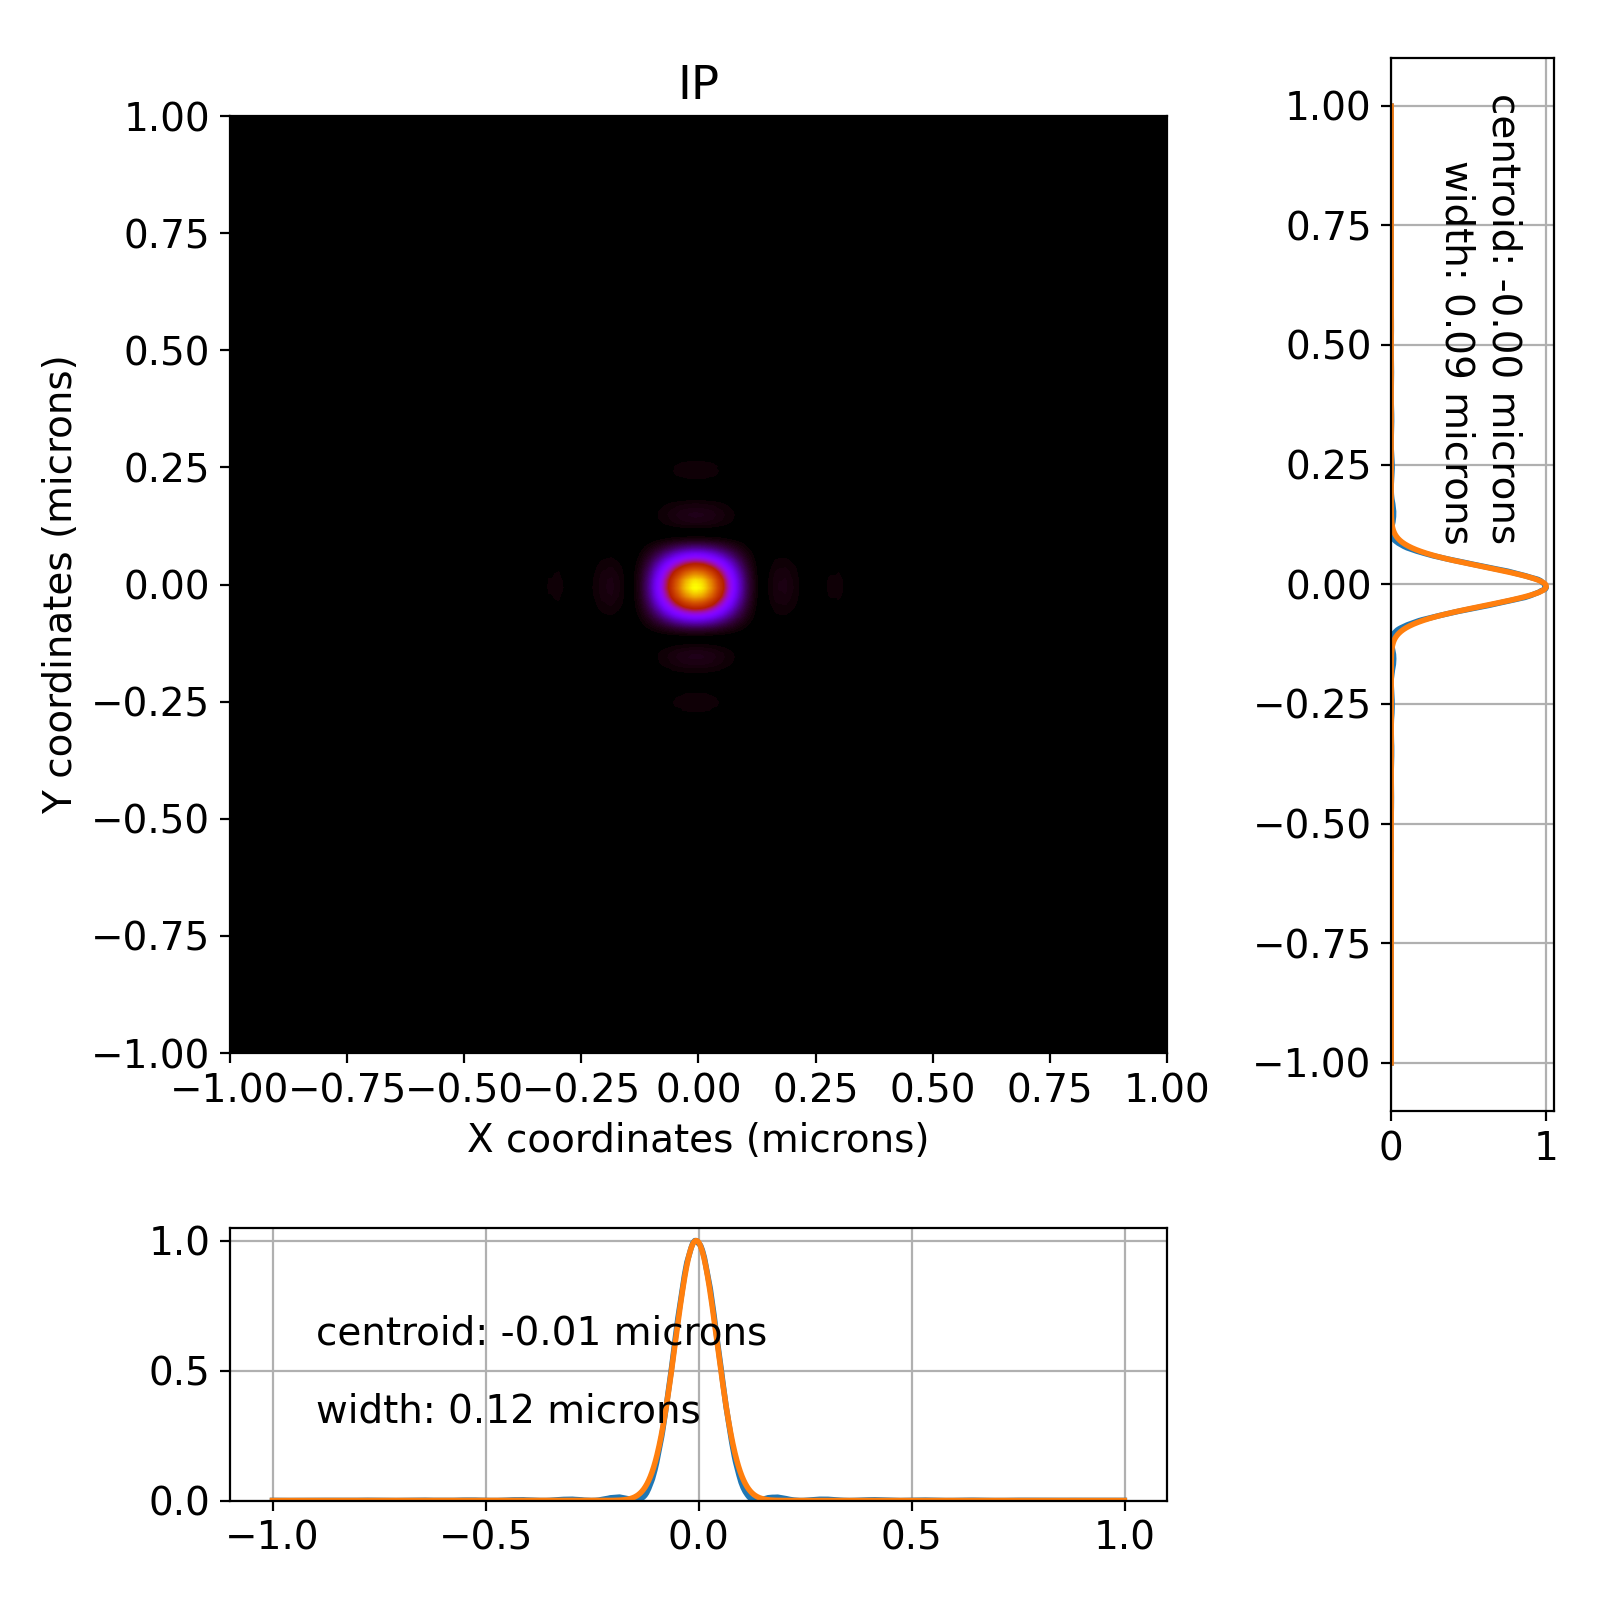

In [20]:
L_beamline.IP.view_beam()

<IPython.core.display.Javascript object>


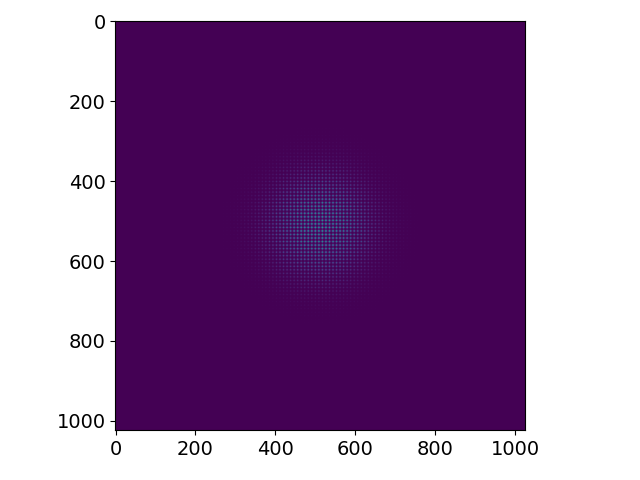

In [23]:
test = np.load('im2l0_sim.npy')
plt.figure()
plt.imshow(test)

## Time-domain propagation

In [34]:
# reset central photon energy
beam_params['photonEnergy'] = 9000

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
pulse = beam.Pulse(beam_params=beam_params, tau=20, time_window=4000)

print('Number of spectral components: {:d}'.format(pulse.N))

Number of spectral components: 449


In [35]:
# propagate pulse through beamline. This will take a minute or so (depends on number of spectral 
# components which is proportional to the ratio time_window/tau).
pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus','im2'])

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311185554481415
5.1311185554481415
x is focused
y is focused
FWHM in x: 345.06333042747747 microns
FWHM in y: 345.06333042747747 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311185554481415
5.1311185554481415
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265500
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: 1646.47
zx: 6.596326
zy: 100.661299
azimuth -0.04 mrad
m1
827.4776969782911
zRx: 6.90e-03
zRy: 4.71e+01
zx: -0.311592
zy: 100.661299
azimuth 13.95 mrad
drift4
delta z: -1646.63
zx

/Users/Matt/beamline/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131119147199961
5.131119147199961
x is focused
y is focused
FWHM in x: 345.0632907373857 microns
FWHM in y: 345.0632907373857 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131119147199961
5.131119147199961
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265506
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596328
zy: 100.661295
azimuth -0.04 mrad
m1
823.7647360692705
zRx: 6.90e-03
zRy: 4.71e+01
zx: -0.311600
zy: 100.661295
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302421


FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311226977108735
5.1311226977108735
x is focused
y is focused
FWHM in x: 345.06305259702754 microns
FWHM in y: 345.06305259702754 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311226977108735
5.1311226977108735
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265540
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596339
zy: 100.661273
azimuth -0.04 mrad
m1
801.4905368126748
zRx: 6.89e-03
zRy: 4.71e+01
zx: -0.311646
zy: 100.661273
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.3

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265573
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596351
zy: 100.661251
azimuth -0.04 mrad
m1
779.2224498711965
zRx: 6.89e-03
zRy: 4.71e+01
zx: -0.311692
zy: 100.661251
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302468
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302468
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012440
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012440
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.89
zx: 0.288209
zy: 101.261152
azimuth 13.95 mrad
m2
zRx: 3.81e+00
zRy: 4.71e+01
zx: 7.091895
zy: 101.261152
azimuth -0.07 mrad
drift7
delta z: 2.98
zx: 7.111256
zy: 101.280514
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.111256
zRx: 3.97e+00
zRy: 4.71e+01
zx: 7.111807
zy: 101.280514
azimuth -443.07 mrad
drift8
delta z: -0.15
zx: 7.420182
zy: 101.588889
azimuth -443.07 mrad
c4
Calculated d

zx: 7.106963
zy: 101.280514
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.106963
zRx: 3.97e+00
zRy: 4.71e+01
zx: 7.107498
zy: 101.280514
azimuth -443.07 mrad
drift8
delta z: -0.15
zx: 7.415872
zy: 101.588889
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.786316
zRx: 6.38e+01
zRy: 4.71e+01
zx: 118.830800
zy: 101.588889
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.930788
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.930788
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131130390484519
5.131130390484519
x is focused
y is focused
FWHM in x: 345.0625366273835 microns
FWHM in y: 345.0625366273835 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131130390484519
5.131130390484519
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focu

zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265635
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596371
zy: 100.661210
azimuth -0.04 mrad
m1
738.413492553149
zRx: 6.87e-03
zRy: 4.71e+01
zx: -0.311776
zy: 100.661210
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302512
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302512
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012484
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012484
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.90
zx: 0.288134
zy: 101.261120
azimuth 13.95 mrad
m2
zRx: 3.82e+00
zRy: 4.71e+01
zx: 7.083995
zy: 101.261120
azimuth -0.07 mrad
drift7
delta z: 2.98
zx: 7.103390
zy: 101.280515
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.103390
zRx: 3.97e+00
zRy: 4.71e+01
zx: 7.103911
zy: 101.280515
azimuth -

zx: 7.409417
zy: 101.588888
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.682918
zRx: 6.37e+01
zRy: 4.71e+01
zx: 118.725429
zy: 101.588888
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.825417
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.825417
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131135716250889
5.131135716250889
x is focused
y is focused
FWHM in x: 345.0621794185375 microns
FWHM in y: 345.0621794185375 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131135716250889
5.131135716250889
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

zRx: 6.86e-03
zRy: 4.71e+01
zx: -0.311845
zy: 100.661177
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302548
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302548
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012520
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012520
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.90
zx: 0.288072
zy: 101.261094
azimuth 13.95 mrad
m2
zRx: 3.82e+00
zRy: 4.71e+01
zx: 7.077544
zy: 101.261094
azimuth -0.07 mrad
drift7
delta z: 2.99
zx: 7.096966
zy: 101.280515
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.096966
zRx: 3.96e+00
zRy: 4.71e+01
zx: 7.097463
zy: 101.280515
azimuth -443.07 mrad
drift8
delta z: -0.15
zx: 7.405836
zy: 101.588888
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.625553
zRx: 6.37e+01
zRy: 4.71e+01
zx: 118.666969
zy: 101.588888
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.766957
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.766957
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.03158005400378

zx: 118.696885
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.696885
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131142225520896
5.131142225520896
x is focused
y is focused
FWHM in x: 345.06174283095623 microns
FWHM in y: 345.06174283095623 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131142225520896
5.131142225520896
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265724
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596402
zy: 100.661151
azimuth -0.04 mrad
m1
679.0916473432621
zRx: 6.

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311457760318095
5.1311457760318095
x is focused
y is focused
FWHM in x: 345.06150469274303 microns
FWHM in y: 345.06150469274303 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311457760318095
5.1311457760318095
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265758
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596413
zy: 100.661129
azimuth -0.04 mrad
m1
656.8571439441423
zRx: 6.84e-03
zRy: 4.71e+01
zx: -0.311945
zy: 100.661129
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.3

zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265791
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596425
zy: 100.661107
azimuth -0.04 mrad
m1
634.6287404254301
zRx: 6.84e-03
zRy: 4.71e+01
zx: -0.311991
zy: 100.661107
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302624
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302624
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012595
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012595
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.91
zx: 0.287941
zy: 101.261039
azimuth 13.95 mrad
m2
zRx: 3.83e+00
zRy: 4.71e+01
zx: 7.063963
zy: 101.261039
azimuth -0.07 mrad
drift7
delta z:

FWHM in x: 345.0610284173067 microns
FWHM in y: 345.0610284173067 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131152877053634
5.131152877053634
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265825
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596436
zy: 100.661084
azimuth -0.04 mrad
m1
612.4064348097128
zRx: 6.83e-03
zRy: 4.71e+01
zx: -0.312037
zy: 100.661084
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302648
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302648
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012619
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012619
zy: 100.960502
azimuth

zx: 118.417380
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131156427564548
5.131156427564548
x is focused
y is focused
FWHM in x: 345.0607902800834 microns
FWHM in y: 345.0607902800834 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131156427564548
5.131156427564548
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265858
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596447
zy: 100.661062
azimuth -0.04 mrad
m1
590.1902253039119
zRx: 6.82e-03
zRy: 4.71e+01
zx: -0.312083
zy: 100.661062
azimu

zx: -0.012663
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.92
zx: 0.287824
zy: 101.260989
azimuth 13.95 mrad
m2
zRx: 3.83e+00
zRy: 4.71e+01
zx: 7.051853
zy: 101.260989
azimuth -0.07 mrad
drift7
delta z: 3.00
zx: 7.071383
zy: 101.280518
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.071383
zRx: 3.95e+00
zRy: 4.71e+01
zx: 7.071786
zy: 101.280518
azimuth -443.07 mrad
drift8
delta z: -0.15
zx: 7.380153
zy: 101.588885
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.214166
zRx: 6.34e+01
zRy: 4.71e+01
zx: 118.247714
zy: 101.588885
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.347704
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.347704
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131159978075462
5.131159978075462
x is focused
y is focused
FWHM in x: 345.0605521431902 microns
FWHM in y: 345.0605521431902 microns
FWHM Divergence (x): 3.4 μrad

zx: 6.596466
zy: 100.661025
azimuth -0.04 mrad
m1
553.1767508913609
zRx: 6.81e-03
zRy: 4.71e+01
zx: -0.312160
zy: 100.661025
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302711
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302711
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012683
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012683
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.92
zx: 0.287789
zy: 101.260975
azimuth 13.95 mrad
m2
zRx: 3.83e+00
zRy: 4.71e+01
zx: 7.048299
zy: 101.260975
azimuth -0.07 mrad
drift7
delta z: 3.01
zx: 7.067844
zy: 101.280519
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.067844
zRx: 3.95e+00
zRy: 4.71e+01
zx: 7.068233
zy: 101.280519
azimuth -443.07 mrad
drift8
delta z: -0.15
zx: 7.376600
zy: 101.588885
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.157256
zRx: 6.34e+01
zRy: 4.71e+01
zx: 118.189714
zy: 101.588885
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.289705
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.2

zx: 7.372341
zy: 101.588885
azimuth -443.07 mrad
c4
Calculated distance to focus: -118.089040
zRx: 6.33e+01
zRy: 4.71e+01
zx: 118.120189
zy: 101.588885
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.220180
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.220180
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131166487345468
5.131166487345468
x is focused
y is focused
FWHM in x: 345.0601155597431 microns
FWHM in y: 345.0601155597431 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131166487345468
5.131166487345468
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.265976
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596487
zy: 100.660985
azimuth -0.04 mrad
m1
512.481470457587
zRx: 6.80e-03
zRy: 4.71e+01
zx: -0.312244
zy: 100.660985
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302755
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302755
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012727
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012727
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.93
zx: 0.287713
zy: 101.260942
azimuth 13.95 mrad
m2
zRx: 3.84e+00
zRy: 4.71e+01
zx: 7.040492
zy: 101.260942
azimuth -0.07 mrad
drift7
delta z: 3.01
zx: 7.060070
zy: 101.280520
azimuth -0.07 mrad
c3
Calculated distance to focus: -7.060070
zRx: 3.94e+00
zRy: 4.71e+01
zx: 7.060431
zy: 101.280520
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.368795
zy: 101.588884
azimuth -443.08 mrad
c4
Calculated distance to focus: -118.032249
zRx: 6.33e+01
zRy: 4.71e

zRx: 3.94e+00
zRy: 4.71e+01
zx: 7.057598
zy: 101.280520
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.365962
zy: 101.588884
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.986856
zRx: 6.33e+01
zRy: 4.71e+01
zx: 118.016045
zy: 101.588884
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.116037
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.116037
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311718131118385
5.1311718131118385
x is focused
y is focused
FWHM in x: 345.0597583559294 microns
FWHM in y: 345.0597583559294 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311718131118385
5.1311718131118385
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.0

Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266026
zy: 100.330473
azimuth -0.04 mrad
drift3
delta z: -3.69
zx: 6.596505
zy: 100.660952
azimuth -0.04 mrad
m1
479.2005510733295
zRx: 6.78e-03
zRy: 4.71e+01
zx: -0.312313
zy: 100.660952
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302791
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302791
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012763
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012763
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.93
zx: 0.287651
zy: 101.260916
azimuth 13.95 mrad
m2
zRx: 3.84e+00
zRy: 4.71e+01
zx: 7.034117
zy: 101.260916
azimuth -0.06 mrad
drift7
delta z: 3.01
zx: 7.053722
zy: 101.280520
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.053722
zRx: 3.94e+00
zRy: 4.7

zx: 7.359593
zy: 101.588884
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.884850
zRx: 6.32e+01
zRy: 4.71e+01
zx: 117.912080
zy: 101.588884
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 118.012073
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 118.012073
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131177138878209
5.131177138878209
x is focused
y is focused
FWHM in x: 345.0594011528582 microns
FWHM in y: 345.0594011528582 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131177138878209
5.131177138878209
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266076
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.69
zx: 6.596522
zy: 100.660919
azimuth -0.05 mrad
m1
445.9333219116764
zRx: 6.77e-03
zRy: 4.71e+01
zx: -0.312382
zy: 100.660919
azimuth 13.95 mrad
drift4
delta z: 3.69
zx: -0.302827
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302827
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012798
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012798
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.93
zx: 0.287589
zy: 101.260890
azimuth 13.95 mrad
m2
zRx: 3.84e+00
zRy: 4.71e+01
zx: 7.027753
zy: 101.260890
azimuth -0.06 mrad
drift7
delta z: 3.02
zx: 7.047384
zy: 101.280521
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.047384
zRx: 3.94e+00
zRy: 4.71e+01
zx: 7.047698
zy: 101.280521
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.356060
zy: 101.588883
azimuth -443.08 mrad
c4
Calculated d

zx: 7.353236
zy: 101.588883
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.783019
zRx: 6.31e+01
zRy: 4.71e+01
zx: 117.808293
zy: 101.588883
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.908286
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.908286
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131182464644579
5.131182464644579
x is focused
y is focused
FWHM in x: 345.0590439505295 microns
FWHM in y: 345.0590439505295 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131182464644579
5.131182464644579
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

zx: -0.302862
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302862
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012834
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012834
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.94
zx: 0.287527
zy: 101.260863
azimuth 13.95 mrad
m2
zRx: 3.85e+00
zRy: 4.71e+01
zx: 7.021399
zy: 101.260863
azimuth -0.06 mrad
drift7
delta z: 3.02
zx: 7.041058
zy: 101.280522
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.041058
zRx: 3.93e+00
zRy: 4.71e+01
zx: 7.041348
zy: 101.280522
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.349709
zy: 101.588883
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.726526
zRx: 6.31e+01
zRy: 4.71e+01
zx: 117.750714
zy: 101.588883
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.850707
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.850707
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y)

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131187790410948
5.131187790410948
x is focused
y is focused
FWHM in x: 345.0586867489433 microns
FWHM in y: 345.0586867489433 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131187790410948
5.131187790410948
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266155
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596548
zy: 100.660867
azimuth -0.05 mrad
m1
394.21149516534007
zRx: 6.76e-03
zRy: 4.71e+01
zx: -0.312489
zy: 100.660867
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.302882

zx: -0.302898
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302898
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012870
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012870
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.94
zx: 0.287465
zy: 101.260837
azimuth 13.95 mrad
m2
zRx: 3.85e+00
zRy: 4.71e+01
zx: 7.015056
zy: 101.260837
azimuth -0.06 mrad
drift7
delta z: 3.03
zx: 7.034742
zy: 101.280523
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.034742
zRx: 3.93e+00
zRy: 4.71e+01
zx: 7.035009
zy: 101.280523
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.343369
zy: 101.588882
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.624968
zRx: 6.31e+01
zRy: 4.71e+01
zx: 117.647202
zy: 101.588882
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.747196
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.747196
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y)

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131194299680955
5.131194299680955
x is focused
y is focused
FWHM in x: 345.0582501702351 microns
FWHM in y: 345.0582501702351 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131194299680955
5.131194299680955
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266216
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596569
zy: 100.660826
azimuth -0.05 mrad
m1
353.5961298617284
zRx: 6.74e-03
zRy: 4.71e+01
zx: -0.312574
zy: 100.660826
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.302926


zx: -0.302942
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302942
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012914
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012914
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.95
zx: 0.287388
zy: 101.260804
azimuth 13.95 mrad
m2
zRx: 3.85e+00
zRy: 4.71e+01
zx: 7.007319
zy: 101.260804
azimuth -0.06 mrad
drift7
delta z: 3.03
zx: 7.027038
zy: 101.280524
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.027038
zRx: 3.92e+00
zRy: 4.71e+01
zx: 7.027276
zy: 101.280524
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.335634
zy: 101.588881
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.501077
zRx: 6.30e+01
zRy: 4.71e+01
zx: 117.520925
zy: 101.588881
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.620919
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.620919
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y)

zx: 117.575063
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311996254473256
5.1311996254473256
x is focused
y is focused
FWHM in x: 345.0578929702988 microns
FWHM in y: 345.0578929702988 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1311996254473256
5.1311996254473256
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266266
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596587
zy: 100.660793
azimuth -0.05 mrad
m1
320.38056139073063
zRx: 6.73e-03
zRy: 4.71e+01
zx: -0.312643
zy: 100.660793


zx: 6.596594
zy: 100.660779
azimuth -0.05 mrad
m1
305.62247139752947
zRx: 6.73e-03
zRy: 4.71e+01
zx: -0.312673
zy: 100.660779
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.302978
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.302978
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.012949
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.012949
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.95
zx: 0.287326
zy: 101.260778
azimuth 13.95 mrad
m2
zRx: 3.86e+00
zRy: 4.71e+01
zx: 7.001000
zy: 101.260778
azimuth -0.06 mrad
drift7
delta z: 3.03
zx: 7.020747
zy: 101.280524
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.020747
zRx: 3.92e+00
zRy: 4.71e+01
zx: 7.020962
zy: 101.280524
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.329318
zy: 101.588881
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.399904
zRx: 6.29e+01
zRy: 4.71e+01
zx: 117.417802
zy: 101.588881
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.517797
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.

zRx: 3.92e+00
zRy: 4.71e+01
zx: 7.016757
zy: 101.280525
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.325113
zy: 101.588880
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.332546
zRx: 6.29e+01
zRy: 4.71e+01
zx: 117.349146
zy: 101.588880
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.449141
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.449141
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131206134717333
5.131206134717333
x is focused
y is focused
FWHM in x: 345.0574563936071 microns
FWHM in y: 345.0574563936071 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131206134717333
5.131206134717333
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mr

FWHM in x: 345.0572182613337 microns
FWHM in y: 345.0572182613337 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131209685228247
5.131209685228247
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266362
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596619
zy: 100.660731
azimuth -0.05 mrad
m1
257.67730646442936
zRx: 6.71e-03
zRy: 4.71e+01
zx: -0.312773
zy: 100.660731
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303029
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303029
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013001
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013001
zy: 100.960502
azimut

zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266395
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596630
zy: 100.660709
azimuth -0.05 mrad
m1
235.55837368190757
zRx: 6.70e-03
zRy: 4.71e+01
zx: -0.312819
zy: 100.660709
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303053
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303053
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013025
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013025
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.96
zx: 0.287194
zy: 101.260722
azimuth 13.95 mrad
m2
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.987695
zy: 101.260722
azimuth -0.06 mrad
drift7
delta z: 3.04
zx: 7.007500
zy: 101.280526
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.007500
zRx: 3.91e+00
zRy: 4.71e+01
zx: 7.007665
zy: 101.280526
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.316019
zy: 101.588880
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.186881
zRx: 6.28e+01
zRy: 4.71e+01
zx: 117.200669
zy: 101.588880
azim

Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266423
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596640
zy: 100.660690
azimuth -0.05 mrad
m1
217.13056167360136
zRx: 6.70e-03
zRy: 4.71e+01
zx: -0.312857
zy: 100.660690
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303073
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303073
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013045
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013045
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.96
zx: 0.287160
zy: 101.260707
azimuth 13.95 mrad
m2
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.984202
zy: 101.260707
azimuth -0.06 mrad
drift7
delta z: 3.05
zx: 7.004021
zy: 101.280527
azimuth -0.06 mrad
c3
Calculated distance to focus: -7.004021
zRx: 3.91e+00
zRy: 4.

zRx: 6.27e+01
zRy: 4.71e+01
zx: 117.075303
zy: 101.588879
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.175300
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.175300
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131220336760985
5.131220336760985
x is focused
y is focused
FWHM in x: 345.0565038664935 microns
FWHM in y: 345.0565038664935 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131220336760985
5.131220336760985
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266462
zy: 100.330473
azimuth -0.05 mrad
d

zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266484
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596661
zy: 100.660650
azimuth -0.05 mrad
m1
176.60419195909307
zRx: 6.69e-03
zRy: 4.71e+01
zx: -0.312941
zy: 100.660650
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303117
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303117
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013089
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013089
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.96
zx: 0.287083
zy: 101.260674
azimuth 13.95 mrad
m2
zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.976528
zy: 101.260674
azimuth -0.06 mrad
drift7
delta z: 3.05
zx: 6.996381
zy: 101.280527
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.996381
zRx: 3.91e+00
zRy: 4.71e+01
zx: 6.996505
zy: 101.280527
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.304856
zy: 101.588879
azimuth -443.08 mrad
c4
Calculated distance to focus: -117.008079
zRx: 6.27e+01
zRy: 4.71e+01
zx: 117.018411
zy: 101.588879
azim

im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266512
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596671
zy: 100.660631
azimuth -0.05 mrad
m1
158.18984723156808
zRx: 6.68e-03
zRy: 4.71e+01
zx: -0.312979
zy: 100.660631
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303137
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303137
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013108
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013108
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.97
zx: 0.287049
zy: 101.260660
azimuth 13.95 mrad
m2
zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.973045
zy: 101.260660
azimuth -0.06 mrad
drift7
del

zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.970261
zy: 101.260648
azimuth -0.06 mrad
drift7
delta z: 3.05
zx: 6.990141
zy: 101.280528
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.990141
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.990242
zy: 101.280528
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.298592
zy: 101.588878
azimuth -443.08 mrad
c4
Calculated distance to focus: -116.907737
zRx: 6.26e+01
zRy: 4.71e+01
zx: 116.916128
zy: 101.588878
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 117.016126
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 117.016126
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131228621286449
5.131228621286449
x is focused
y is focused
FWHM in x: 345.05594822811526 microns
FWHM in y: 345.05594822811526 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131228621286449
5.131228621286449
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
d

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266563
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596688
zy: 100.660598
azimuth -0.05 mrad
m1
125.05462564628263
zRx: 6.67e-03
zRy: 4.71e+01
zx: -0.313048
zy: 100.660598
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303172
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303172
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013144
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013144
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.97
zx: 0.286986
zy: 101.260633
azimuth 13.95 mrad
m2
zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.966783
zy: 101.260633
azimuth -0.06 mrad
drift7
delta z: 3.06
zx: 6.986679
zy: 101.280529
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.986679
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.986767
zy: 101.280529
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.295116
zy: 101.588878
azimuth -443.08 mrad
c4
Calculated 

zRx: 6.26e+01
zRy: 4.71e+01
zx: 116.814015
zy: 101.588877
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.914014
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.914014
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131233947052818
5.131233947052818
x is focused
y is focused
FWHM in x: 345.0555910329637 microns
FWHM in y: 345.0555910329637 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131233947052818
5.131233947052818
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266591
zy: 100.330473
azimuth -0.05 mrad
d

zx: -0.013180
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.97
zx: 0.286924
zy: 101.260606
azimuth 13.95 mrad
m2
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.960532
zy: 101.260606
azimuth -0.06 mrad
drift7
delta z: 3.06
zx: 6.980456
zy: 101.280529
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.980456
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.980520
zy: 101.280529
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.288868
zy: 101.588877
azimuth -443.08 mrad
c4
Calculated distance to focus: -116.751983
zRx: 6.25e+01
zRy: 4.71e+01
zx: 116.757358
zy: 101.588877
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.857357
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.857357
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131236905811914
5.131236905811914
x is focused
y is focused
FWHM in x: 345.0553925915336 microns
FWHM in y: 345.0553925915336 microns
FWHM Divergence (x): 3.4 μrad

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266641
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596715
zy: 100.660547
azimuth -0.05 mrad
m1
73.53802044549612
zRx: 6.65e-03
zRy: 4.71e+01
zx: -0.313155
zy: 100.660547
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303228
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303228
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013200
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013200
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.98
zx: 0.286889
zy: 101.260591
azimuth 13.95 mrad
m2
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.957064
zy: 101.260591
azimuth -0.06 mrad
drift7
delta z: 3.06
zx: 6.977002
zy: 101.280530
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.977002
zRx: 3.89e+00
zRy: 4.71e+01
zx: 6.977054
zy: 101.280530
azimuth -443.08 mrad
drift8
delta z: -0.15
zx: 7.285401
zy: 101.588877
azimuth -443.08 mrad
c4
Calculated d

zx: 6.596726
zy: 100.660525
azimuth -0.05 mrad
m1
51.46955956526411
zRx: 6.65e-03
zRy: 4.71e+01
zx: -0.313201
zy: 100.660525
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303252
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303252
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013224
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013224
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.98
zx: 0.286847
zy: 101.260573
azimuth 13.95 mrad
m2
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.952906
zy: 101.260573
azimuth -0.06 mrad
drift7
delta z: 3.06
zx: 6.972863
zy: 101.280530
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.972863
zRx: 3.89e+00
zRy: 4.71e+01
zx: 6.972899
zy: 101.280530
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.281245
zy: 101.588876
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.629886
zRx: 6.25e+01
zRy: 4.71e+01
zx: 116.632895
zy: 101.588876
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.732894
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.7

Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266702
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596736
zy: 100.660506
azimuth -0.05 mrad
m1
33.08379540093528
zRx: 6.64e-03
zRy: 4.71e+01
zx: -0.313240
zy: 100.660506
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303272
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303272
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013243
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013243
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.98
zx: 0.286813
zy: 101.260558
azimuth 13.95 mrad
m2
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.949445
zy: 101.260558
azimuth -0.06 mrad
drift7
delta z: 3.07
zx: 6.969418
zy: 101.280531
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.969418
zRx: 3.89e+00
zRy: 4.7

zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.946678
zy: 101.260546
azimuth -0.06 mrad
drift7
delta z: 3.07
zx: 6.966663
zy: 101.280531
azimuth -0.06 mrad
c3
Calculated distance to focus: -6.966663
zRx: 3.89e+00
zRy: 4.71e+01
zx: 6.966676
zy: 101.280531
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.275021
zy: 101.588876
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.530180
zRx: 6.24e+01
zRy: 4.71e+01
zx: 116.531254
zy: 101.588876
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.631253
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.631253
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131248740848291
5.131248740848291
x is focused
y is focused
FWHM in x: 345.0545988281049 microns
FWHM in y: 345.0545988281049 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131248740848291
5.131248740848291
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
dri

FWHM in x: 345.05444007585913 microns
FWHM in y: 345.05444007585913 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131251107855566
5.131251107855566
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266753
zy: 100.330473
azimuth -0.05 mrad
drift3
delta z: -3.68
zx: 6.596753
zy: 100.660473
azimuth -0.05 mrad
m1
0.0
zRx: 6.63e-03
zRy: 4.71e+01
zx: -0.313308
zy: 100.660473
azimuth 13.95 mrad
drift4
delta z: 3.68
zx: -0.303307
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303307
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013279
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013279
zy: 100.960502
azimuth 13.95 mrad


Calculated distance to focus: -116.430629
zRx: 6.23e+01
zRy: 4.71e+01
zx: 116.429770
zy: 101.588875
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.529770
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.529770
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131254066614661
5.131254066614661
x is focused
y is focused
FWHM in x: 345.0542416357581 microns
FWHM in y: 345.0542416357581 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131254066614661
5.131254066614661
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266803
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596770
zy: 100.660440
azimuth -0.06 mrad
m1
-33.07019790883115
zRx: 6.62e-03
zRy: 4.71e+01
zx: -0.313377
zy: 100.660440
azimuth 13.95 mrad
drift4
delta z: 3.67
zx: -0.303343
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303343
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013315
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013315
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.99
zx: 0.286687
zy: 101.260505
azimuth 13.95 mrad
m2
zRx: 3.89e+00
zRy: 4.71e+01
zx: 6.937011
zy: 101.260505
azimuth -0.05 mrad
drift7
delta z: 3.07
zx: 6.957038
zy: 101.280532
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.957038
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.957015
zy: 101.280532
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.265358
zy: 101.588875
azimuth -443.09 mrad
c4
Calculated 

Calculated distance to focus: -6.954293
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.954260
zy: 101.280533
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.262602
zy: 101.588875
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.331255
zRx: 6.23e+01
zRy: 4.71e+01
zx: 116.328465
zy: 101.588875
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.428466
zy: 101.688876
azimuth -0.03 mrad
im2
zx: 116.428466
zy: 101.688876
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13125939238103
5.13125939238103
x is focused
y is focused
FWHM in x: 345.05388444415377 microns
FWHM in y: 345.05388444415377 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13125939238103
5.13125939238103
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.0

zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266853
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596787
zy: 100.660407
azimuth -0.06 mrad
m1
-66.12680462754503
zRx: 6.61e-03
zRy: 4.71e+01
zx: -0.313446
zy: 100.660407
azimuth 13.95 mrad
drift4
delta z: 3.67
zx: -0.303379
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303379
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013351
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013351
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -2.99
zx: 0.286625
zy: 101.260478
azimuth 13.95 mrad
m2
zRx: 3.89e+00
zRy: 4.71e+01
zx: 6.930809
zy: 101.260478
azimuth -0.05 mrad
drift7
delta z: 3.08
zx: 6.950864
zy: 101.280533
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.950864
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.950818
zy: 101.280533
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.259159
zy: 101.588874
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.276112
zRx: 6.23e+01
zRy: 4.71e+01
zx: 116.272250
zy: 101.588874
azim

zRx: 6.22e+01
zRy: 4.71e+01
zx: 116.227316
zy: 101.588874
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.327318
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 116.327318
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1312647181474
5.1312647181474
x is focused
y is focused
FWHM in x: 345.05352725329186 microns
FWHM in y: 345.05352725329186 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1312647181474
5.1312647181474
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266881
zy: 100.330473
azimuth -0.06 mrad
drift3


zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266904
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596804
zy: 100.660374
azimuth -0.06 mrad
m1
-99.16982660557929
zRx: 6.60e-03
zRy: 4.71e+01
zx: -0.313515
zy: 100.660374
azimuth 13.95 mrad
drift4
delta z: 3.67
zx: -0.303415
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303415
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013386
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013386
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -3.00
zx: 0.286562
zy: 101.260451
azimuth 13.95 mrad
m2
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.924617
zy: 101.260451
azimuth -0.05 mrad
drift7
delta z: 3.08
zx: 6.944700
zy: 101.280534
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.944700
zRx: 3.88e+00
zRy: 4.71e+01
zx: 6.944631
zy: 101.280534
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.252971
zy: 101.588874
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.176987
zRx: 6.22e+01
zRy: 4.71e+01
zx: 116.171197
zy: 101.588874
azim

zx: 116.226338
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 116.226338
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13127004391377
5.13127004391377
x is focused
y is focused
FWHM in x: 345.0531700631724 microns
FWHM in y: 345.0531700631724 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13127004391377
5.13127004391377
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.266932
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596814
zy: 100.660356
azimuth -0.06 mrad
m1
-117.52119348383003
zRx: 6.59e-

zx: 6.596822
zy: 100.660341
azimuth -0.06 mrad
m1
-132.19927025725488
zRx: 6.59e-03
zRy: 4.71e+01
zx: -0.313584
zy: 100.660341
azimuth 13.95 mrad
drift4
delta z: 3.67
zx: -0.303450
zy: 100.670474
azimuth 13.95 mrad
im1
zx: -0.303450
zy: 100.670474
azimuth 13.95 mrad
drift5
delta z: -0.00
zx: -0.013422
zy: 100.960502
azimuth 13.95 mrad
focus
zx: -0.013422
zy: 100.960502
azimuth 13.95 mrad
drift6
delta z: -3.00
zx: 0.286499
zy: 101.260424
azimuth 13.95 mrad
m2
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.918436
zy: 101.260424
azimuth -0.05 mrad
drift7
delta z: 3.09
zx: 6.938547
zy: 101.280535
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.938547
zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.938454
zy: 101.280535
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.246792
zy: 101.588873
azimuth -443.09 mrad
c4
Calculated distance to focus: -116.078023
zRx: 6.21e+01
zRy: 4.71e+01
zx: 116.070306
zy: 101.588873
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.170308
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 116

Calculated distance to focus: -116.034091
zRx: 6.21e+01
zRy: 4.71e+01
zx: 116.025518
zy: 101.588873
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 116.125520
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 116.125520
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13127536968014
5.13127536968014
x is focused
y is focused
FWHM in x: 345.05281287379535 microns
FWHM in y: 345.05281287379535 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13127536968014
5.13127536968014
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.26

Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267004
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596839
zy: 100.660308
azimuth -0.06 mrad
m1
-165.2151418744964
zRx: 6.58e-03
zRy: 4.71e+01
zx: -0.313652
zy: 100.660308
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303486
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303486
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013458
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013458
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.00
zx: 0.286437
zy: 101.260397
azimuth 13.94 mrad
m2
zRx: 3.90e+00
zRy: 4.71e+01
zx: 6.912264
zy: 101.260397
azimuth -0.05 mrad
drift7
delta z: 3.09
zx: 6.932403
zy: 101.280535
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.932403
zRx: 3.87e+00
zRy: 4.71e+01
zx: 6.932287
zy: 101.280535
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.240624
zy: 101.588873
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.979222
zRx: 6.21e+01
zRy: 4.7

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131280695446508
5.131280695446508
x is focused
y is focused
FWHM in x: 345.05245568516085 microns
FWHM in y: 345.05245568516085 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131280695446508
5.131280695446508
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267032
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596849
zy: 100.660290
azimuth -0.06 mrad
m1
-183.55143069913908
zRx: 6.57e-03
zRy: 4.71e+01
zx: -0.313691
zy: 100.660290
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303

zRx: 6.57e-03
zRy: 4.71e+01
zx: -0.313721
zy: 100.660275
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303522
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303522
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013494
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013494
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.01
zx: 0.286374
zy: 101.260370
azimuth 13.94 mrad
m2
zRx: 3.91e+00
zRy: 4.71e+01
zx: 6.906103
zy: 101.260370
azimuth -0.05 mrad
drift7
delta z: 3.09
zx: 6.926269
zy: 101.280536
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.926269
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.926130
zy: 101.280536
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.234466
zy: 101.588872
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.880580
zRx: 6.20e+01
zRy: 4.71e+01
zx: 115.869014
zy: 101.588872
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.969018
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.969018
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.03158005400378

zRx: 6.20e+01
zRy: 4.71e+01
zx: 115.824369
zy: 101.588872
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.924372
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.924372
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131286021212879
5.131286021212879
x is focused
y is focused
FWHM in x: 345.0520984972686 microns
FWHM in y: 345.0520984972686 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131286021212879
5.131286021212879
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267082
zy: 100.330473
azimuth -0.06 mrad
d

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267105
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596873
zy: 100.660242
azimuth -0.06 mrad
m1
-231.2061947529406
zRx: 6.56e-03
zRy: 4.71e+01
zx: -0.313790
zy: 100.660242
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303558
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303558
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013529
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013529
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.01
zx: 0.286311
zy: 101.260343
azimuth 13.94 mrad
m2
zRx: 3.91e+00
zRy: 4.71e+01
zx: 6.899951
zy: 101.260343
azimuth -0.05 mrad
drift7
delta z: 3.10
zx: 6.920145
zy: 101.280537
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.920145
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.919983
zy: 101.280537
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.228318
zy: 101.588872
azimuth -443.09 mrad
c4
Calculated 

zx: 6.917427
zy: 101.280537
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.917427
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.917255
zy: 101.280537
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.225589
zy: 101.588871
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.738384
zRx: 6.19e+01
zRy: 4.71e+01
zx: 115.724044
zy: 101.588871
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.824048
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.824048
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131291346979248
5.131291346979248
x is focused
y is focused
FWHM in x: 345.0517413101189 microns
FWHM in y: 345.0517413101189 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131291346979248
5.131291346979248
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focu

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267155
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596891
zy: 100.660209
azimuth -0.06 mrad
m1
-264.1813886991508
zRx: 6.54e-03
zRy: 4.71e+01
zx: -0.313859
zy: 100.660209
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303593
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303593
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013565
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013565
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.02
zx: 0.286248
zy: 101.260316
azimuth 13.94 mrad
m2
zRx: 3.91e+00
zRy: 4.71e+01
zx: 6.893809
zy: 101.260316
azimuth -0.05 mrad
drift7
delta z: 3.10
zx: 6.914032
zy: 101.280538
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.914032
zRx: 3.86e+00
zRy: 4.71e+01
zx: 6.913846
zy: 101.280538
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.222180
zy: 101.588871
azimuth -443.09 mrad
c4
Calculated 

zx: 7.219455
zy: 101.588871
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.640133
zRx: 6.19e+01
zRy: 4.71e+01
zx: 115.623874
zy: 101.588871
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.723878
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.723878
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131296672745617
5.131296672745617
x is focused
y is focused
FWHM in x: 345.0513841237117 microns
FWHM in y: 345.0513841237117 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131296672745617
5.131296672745617
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267205
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596908
zy: 100.660176
azimuth -0.06 mrad
m1
-297.1430361605538
zRx: 6.53e-03
zRy: 4.71e+01
zx: -0.313927
zy: 100.660176
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303629
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303629
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013601
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013601
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.02
zx: 0.286185
zy: 101.260288
azimuth 13.94 mrad
m2
zRx: 3.92e+00
zRy: 4.71e+01
zx: 6.887678
zy: 101.260288
azimuth -0.05 mrad
drift7
delta z: 3.10
zx: 6.907928
zy: 101.280539
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.907928
zRx: 3.85e+00
zRy: 4.71e+01
zx: 6.907719
zy: 101.280539
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.216051
zy: 101.588870
azimuth -443.09 mrad
c4
Calculated 

zRx: 3.85e+00
zRy: 4.71e+01
zx: 6.905000
zy: 101.280539
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.213331
zy: 101.588870
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.542044
zRx: 6.18e+01
zRy: 4.71e+01
zx: 115.523867
zy: 101.588870
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.623872
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.623872
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131301998511988
5.131301998511988
x is focused
y is focused
FWHM in x: 345.0510269380467 microns
FWHM in y: 345.0510269380467 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131301998511988
5.131301998511988
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mr

zx: -0.313996
zy: 100.660143
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303665
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303665
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013636
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013636
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.02
zx: 0.286122
zy: 101.260261
azimuth 13.94 mrad
m2
zRx: 3.92e+00
zRy: 4.71e+01
zx: 6.881555
zy: 101.260261
azimuth -0.05 mrad
drift7
delta z: 3.11
zx: 6.901833
zy: 101.280539
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.901833
zRx: 3.85e+00
zRy: 4.71e+01
zx: 6.901602
zy: 101.280539
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.209933
zy: 101.588870
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.487610
zRx: 6.18e+01
zRy: 4.71e+01
zx: 115.468369
zy: 101.588870
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.568374
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.568374
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.0315

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131307324278358
5.131307324278358
x is focused
y is focused
FWHM in x: 345.05066975312417 microns
FWHM in y: 345.05066975312417 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131307324278358
5.131307324278358
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267284
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596935
zy: 100.660124
azimuth -0.06 mrad
m1
-348.38979918274646
zRx: 6.52e-03
zRy: 4.71e+01
zx: -0.314034
zy: 100.660124
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303

zx: 0.286045
zy: 101.260228
azimuth 13.94 mrad
m2
zRx: 3.93e+00
zRy: 4.71e+01
zx: 6.874087
zy: 101.260228
azimuth -0.05 mrad
drift7
delta z: 3.11
zx: 6.894399
zy: 101.280540
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.894399
zRx: 3.85e+00
zRy: 4.71e+01
zx: 6.894140
zy: 101.280540
azimuth -443.09 mrad
drift8
delta z: -0.15
zx: 7.202468
zy: 101.588869
azimuth -443.09 mrad
c4
Calculated distance to focus: -115.368047
zRx: 6.17e+01
zRy: 4.71e+01
zx: 115.346465
zy: 101.588869
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.446471
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.446471
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313114665410895
5.1313114665410895
x is focused
y is focused
FWHM in x: 345.05039194314224 microns
FWHM in y: 345.05039194314224 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313114665410895
5.13131146654108

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267356
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.67
zx: 6.596960
zy: 100.660077
azimuth -0.06 mrad
m1
-395.9467631957553
zRx: 6.50e-03
zRy: 4.71e+01
zx: -0.314133
zy: 100.660077
azimuth 13.94 mrad
drift4
delta z: 3.67
zx: -0.303736
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303736
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013708
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013708
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.03
zx: 0.285996
zy: 101.260207
azimuth 13.94 mrad
m2
zRx: 3.93e+00
zRy: 4.71e+01
zx: 6.869341
zy: 101.260207
azimuth -0.05 mrad
drift7
delta z: 3.12
zx: 6.889675
zy: 101.280541
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.889675
zRx: 3.84e+00
zRy: 4.71e+01
zx: 6.889398
zy: 101.280541
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.197726
zy: 101.588869
azimuth -443.10 mrad
c4
Calculated 

Calculated distance to focus: -115.248710
zRx: 6.17e+01
zRy: 4.71e+01
zx: 115.224791
zy: 101.588868
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.324797
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.324797
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131317975811097
5.131317975811097
x is focused
y is focused
FWHM in x: 345.04995538550645 microns
FWHM in y: 345.04995538550645 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131317975811097
5.131317975811097
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 

zx: -0.013744
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013744
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.03
zx: 0.285933
zy: 101.260179
azimuth 13.94 mrad
m2
zRx: 3.93e+00
zRy: 4.71e+01
zx: 6.863248
zy: 101.260179
azimuth -0.05 mrad
drift7
delta z: 3.12
zx: 6.883610
zy: 101.280542
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.883610
zRx: 3.84e+00
zRy: 4.71e+01
zx: 6.883310
zy: 101.280542
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.191637
zy: 101.588868
azimuth -443.10 mrad
c4
Calculated distance to focus: -115.194546
zRx: 6.16e+01
zRy: 4.71e+01
zx: 115.169565
zy: 101.588868
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.269572
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.269572
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131320934570192
5.131320934570192
x is focused
y is focused
FWHM in x: 345.0497569505841 microns
FWHM in y: 3

zx: -0.013763
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.04
zx: 0.285898
zy: 101.260164
azimuth 13.94 mrad
m2
zRx: 3.94e+00
zRy: 4.71e+01
zx: 6.859868
zy: 101.260164
azimuth -0.05 mrad
drift7
delta z: 3.12
zx: 6.880245
zy: 101.280542
azimuth -0.05 mrad
c3
Calculated distance to focus: -6.880245
zRx: 3.84e+00
zRy: 4.71e+01
zx: 6.879932
zy: 101.280542
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.188258
zy: 101.588868
azimuth -443.10 mrad
c4
Calculated distance to focus: -115.140428
zRx: 6.16e+01
zRy: 4.71e+01
zx: 115.114386
zy: 101.588868
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.214393
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.214393
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131323893329286
5.131323893329286
x is focused
y is focused
FWHM in x: 345.04955851589096 microns
FWHM in y: 345.04955851589096 microns
FWHM Divergence (x): 3.4 μr

zx: -0.303811
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303811
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013783
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013783
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.04
zx: 0.285863
zy: 101.260149
azimuth 13.94 mrad
m2
zRx: 3.94e+00
zRy: 4.71e+01
zx: 6.856490
zy: 101.260149
azimuth -0.04 mrad
drift7
delta z: 3.13
zx: 6.876883
zy: 101.280543
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.876883
zRx: 3.84e+00
zRy: 4.71e+01
zx: 6.876558
zy: 101.280543
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.184883
zy: 101.588867
azimuth -443.10 mrad
c4
Calculated distance to focus: -115.086362
zRx: 6.16e+01
zRy: 4.71e+01
zx: 115.059258
zy: 101.588867
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.159266
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.159266
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y)

zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267490
zy: 100.330473
azimuth -0.06 mrad
drift3
delta z: -3.66
zx: 6.597006
zy: 100.659989
azimuth -0.06 mrad
m1
-483.67013385729337
zRx: 6.48e-03
zRy: 4.71e+01
zx: -0.314317
zy: 100.659989
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.303831
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303831
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013803
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013803
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.04
zx: 0.285828
zy: 101.260134
azimuth 13.94 mrad
m2
zRx: 3.94e+00
zRy: 4.71e+01
zx: 6.853115
zy: 101.260134
azimuth -0.04 mrad
drift7
delta 

FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13133217785475
5.13133217785475
x is focused
y is focused
FWHM in x: 345.049002899969 microns
FWHM in y: 345.049002899969 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13133217785475
5.13133217785475
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267518
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597016
zy: 100.659971
azimuth -0.07 mrad
m1
-501.9337451179838
zRx: 6.47e-03
zRy: 4.71e+01
zx: -0.314355
zy: 100.659971
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.303851
zy: 1

zx: 7.175447
zy: 101.588867
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.935216
zRx: 6.15e+01
zRy: 4.71e+01
zx: 114.905145
zy: 101.588867
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 115.005154
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 115.005154
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131335136613844
5.131335136613844
x is focused
y is focused
FWHM in x: 345.0488044661465 microns
FWHM in y: 345.0488044661465 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131335136613844
5.131335136613844
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to

delta z: 3.13
zx: 6.864134
zy: 101.280544
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.864134
zRx: 3.83e+00
zRy: 4.71e+01
zx: 6.863760
zy: 101.280544
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.172082
zy: 101.588866
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.881328
zRx: 6.14e+01
zRy: 4.71e+01
zx: 114.850198
zy: 101.588866
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.950207
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.950207
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131338095372938
5.131338095372938
x is focused
y is focused
FWHM in x: 345.04860603255315 microns
FWHM in y: 345.04860603255315 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131338095372938
5.131338095372938
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated 

zx: 0.285695
zy: 101.260076
azimuth 13.94 mrad
m2
zRx: 3.95e+00
zRy: 4.71e+01
zx: 6.840318
zy: 101.260076
azimuth -0.04 mrad
drift7
delta z: 3.14
zx: 6.860787
zy: 101.280545
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.860787
zRx: 3.83e+00
zRy: 4.71e+01
zx: 6.860400
zy: 101.280545
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.168721
zy: 101.588866
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.827486
zRx: 6.14e+01
zRy: 4.71e+01
zx: 114.795299
zy: 101.588866
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.895308
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.895308
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131341054132033
5.131341054132033
x is focused
y is focused
FWHM in x: 345.04840759918903 microns
FWHM in y: 345.04840759918903 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131341054132033
5.131341054132033
i

zx: -0.013898
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013898
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.05
zx: 0.285660
zy: 101.260061
azimuth 13.94 mrad
m2
zRx: 3.95e+00
zRy: 4.71e+01
zx: 6.836957
zy: 101.260061
azimuth -0.04 mrad
drift7
delta z: 3.14
zx: 6.857442
zy: 101.280545
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.857442
zRx: 3.83e+00
zRy: 4.71e+01
zx: 6.857042
zy: 101.280545
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.165362
zy: 101.588866
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.773691
zRx: 6.14e+01
zRy: 4.71e+01
zx: 114.740445
zy: 101.588866
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.840455
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.840455
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131344012891127
5.131344012891127
x is focused
y is focused
FWHM in x: 345.0482091660539 microns
FWHM in y: 3

zx: -0.013918
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013918
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.05
zx: 0.285625
zy: 101.260046
azimuth 13.94 mrad
m2
zRx: 3.95e+00
zRy: 4.71e+01
zx: 6.833600
zy: 101.260046
azimuth -0.04 mrad
drift7
delta z: 3.14
zx: 6.854100
zy: 101.280546
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.854100
zRx: 3.82e+00
zRy: 4.71e+01
zx: 6.853687
zy: 101.280546
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.162007
zy: 101.588865
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.719945
zRx: 6.13e+01
zRy: 4.71e+01
zx: 114.685642
zy: 101.588865
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.785652
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.785652
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313469716502205
5.1313469716502205
x is focused
y is focused
FWHM in x: 345.0480107331481 microns
FWHM in y:

zx: 6.597071
zy: 100.659864
azimuth -0.07 mrad
m1
-607.7805539627188
zRx: 6.44e-03
zRy: 4.71e+01
zx: -0.314576
zy: 100.659864
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.303966
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303966
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013938
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013938
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.05
zx: 0.285590
zy: 101.260030
azimuth 13.94 mrad
m2
zRx: 3.95e+00
zRy: 4.71e+01
zx: 6.830245
zy: 101.260030
azimuth -0.04 mrad
drift7
delta z: 3.14
zx: 6.850761
zy: 101.280546
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.850761
zRx: 3.82e+00
zRy: 4.71e+01
zx: 6.850336
zy: 101.280546
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.158655
zy: 101.588865
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.666246
zRx: 6.13e+01
zRy: 4.71e+01
zx: 114.630886
zy: 101.588865
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.730896
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267708
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597081
zy: 100.659846
azimuth -0.07 mrad
m1
-626.0158519949238
zRx: 6.43e-03
zRy: 4.71e+01
zx: -0.314614
zy: 100.659846
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.303986
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.303986
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.013958
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.013958
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.06
zx: 0.285555
zy: 101.260015
azimuth 13.94 mrad
m2
zRx: 3.96e+00
zRy: 4.71e+01
zx: 6.826893
zy: 101.260015
azimuth -0.04 mrad
drift7
delta z: 3.14
zx: 6.847424
zy: 101.280546
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.847424
zRx: 3.82e+00
zRy: 4.71e+01
zx: 6.846986
zy: 101.280546
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.155305
zy: 101.588865
azimuth -443.10 mrad
c4
Calculated 

FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131355256175685
5.131355256175685
x is focused
y is focused
FWHM in x: 345.0474551222304 microns
FWHM in y: 345.0474551222304 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131355256175685
5.131355256175685
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267736
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597091
zy: 100.659828
azimuth -0.07 mrad
m1
-644.2469905023141
zRx: 6.43e-03
zRy: 4.71e+01
zx: -0.314652
zy: 100.659828
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.304006
zy: 100.670474
azimuth 13.94 mrad
im1

zx: 114.577823
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13135821493478
5.13135821493478
x is focused
y is focused
FWHM in x: 345.0472566901952 microns
FWHM in y: 345.0472566901952 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.13135821493478
5.13135821493478
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267764
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597100
zy: 100.659809
azimuth -0.07 mrad
m1
-662.4739706898308
zRx: 6.42e-03
zRy: 4.71e+01
zx: -0.314690
zy: 100.659809
azimuth 

zx: 114.523244
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.523244
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313611736938745
5.1313611736938745
x is focused
y is focused
FWHM in x: 345.04705825838903 microns
FWHM in y: 345.04705825838903 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313611736938745
5.1313611736938745
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267792
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597110
zy: 100.659791
azimuth -0.07 mrad
m1
-680.6967935511927
zR

zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267831
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597123
zy: 100.659766
azimuth -0.07 mrad
m1
-706.2017632697127
zRx: 6.41e-03
zRy: 4.71e+01
zx: -0.314782
zy: 100.659766
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.304073
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.304073
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.014045
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.014045
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.07
zx: 0.285400
zy: 101.259948
azimuth 13.94 mrad
m2
zRx: 3.97e+00
zRy: 4.71e+01
zx: 6.812179
zy: 101.259948
azimuth -0.04 mrad
drift7
delta z

Calculated distance to focus: -6.828795
zRx: 3.81e+00
zRy: 4.71e+01
zx: 6.828286
zy: 101.280549
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.136600
zy: 101.588863
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.312983
zRx: 6.11e+01
zRy: 4.71e+01
zx: 114.270662
zy: 101.588863
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.370674
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.370674
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131369458219338
5.131369458219338
x is focused
y is focused
FWHM in x: 345.0465026505511 microns
FWHM in y: 345.0465026505511 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131369458219338
5.131369458219338
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100

zx: 6.597149
zy: 100.659718
azimuth -0.07 mrad
m1
-753.5465335621273
zRx: 6.39e-03
zRy: 4.71e+01
zx: -0.314881
zy: 100.659718
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.304125
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.304125
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.014096
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.014096
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.07
zx: 0.285309
zy: 101.259908
azimuth 13.94 mrad
m2
zRx: 3.97e+00
zRy: 4.71e+01
zx: 6.803510
zy: 101.259908
azimuth -0.04 mrad
drift7
delta z: 3.16
zx: 6.824152
zy: 101.280549
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.824152
zRx: 3.81e+00
zRy: 4.71e+01
zx: 6.823626
zy: 101.280549
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.131939
zy: 101.588862
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.238314
zRx: 6.11e+01
zRy: 4.71e+01
zx: 114.194518
zy: 101.588862
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.294531
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.

zx: -0.014120
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.014120
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.07
zx: 0.285267
zy: 101.259889
azimuth 13.94 mrad
m2
zRx: 3.98e+00
zRy: 4.71e+01
zx: 6.799516
zy: 101.259889
azimuth -0.04 mrad
drift7
delta z: 3.16
zx: 6.820177
zy: 101.280550
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.820177
zRx: 3.80e+00
zRy: 4.71e+01
zx: 6.819635
zy: 101.280550
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.127947
zy: 101.588862
azimuth -443.10 mrad
c4
Calculated distance to focus: -114.174378
zRx: 6.10e+01
zRy: 4.71e+01
zx: 114.129320
zy: 101.588862
azimuth -0.03 mrad
drift9
delta z: 0.06
zx: 114.229333
zy: 101.688875
azimuth -0.03 mrad
im2
zx: 114.229333
zy: 101.688875
azimuth -0.03 mrad
FWHM in x: 25.031580054003783 microns
FWHM in y: 25.031580054003783 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.131377150992983
5.131377150992983
x is focused
y is focused
FWHM in x: 345.0459867305957 microns
FWHM in y: 3

zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.267976
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597174
zy: 100.659670
azimuth -0.07 mrad
m1
-800.8632371322004
zRx: 6.38e-03
zRy: 4.71e+01
zx: -0.314980
zy: 100.659670
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.304176
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.304176
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.014148
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.014148
zy: 100.960502
azimuth 13.94 mrad
drift6
delta z: -3.08
zx: 0.285217
zy: 101.259868
azimuth 13.94 mrad
m2
zRx: 3.98e+00
zRy: 4.71e+01
zx: 6.794861
zy: 101.259868
azimuth -0.04 mrad
drift7
delta z: 3.16
zx: 6.815544
zy: 101.280551
azimuth -0.04 mrad
c3
Calculated distance to focus: -6.815544
zRx: 3.80e+00
zRy: 4.71e+01
zx: 6.814984
zy: 101.280551
azimuth -443.10 mrad
drift8
delta z: -0.15
zx: 7.123295
zy: 101.588862
azimuth -443.10 mrad
c4
Calculated 

FWHM in x: 345.04555018415095 microns
FWHM in y: 345.04555018415095 microns
FWHM Divergence (x): 3.4 μrad
FWHM Divergence (y): 3.4 μrad
5.1313836602629905
5.1313836602629905
im0
zx: 99.900000
zy: 99.900000
azimuth 0.00 mrad
drift1
delta z: 0.00
zx: 100.000000
zy: 100.000000
azimuth 0.00 mrad
c1
Calculated distance to focus: -100.000000
zRx: 4.71e+01
zRy: 4.71e+01
zx: 100.000000
zy: 100.000000
azimuth 443.03 mrad
drift2
delta z: 0.00
zx: 100.330473
zy: 100.330473
azimuth 443.03 mrad
c2
Calculated distance to focus: -6.266753
zRx: 2.94e+00
zRy: 4.71e+01
zx: 6.268004
zy: 100.330473
azimuth -0.07 mrad
drift3
delta z: -3.66
zx: 6.597183
zy: 100.659652
azimuth -0.07 mrad
m1
-819.0544998477519
zRx: 6.37e-03
zRy: 4.71e+01
zx: -0.315018
zy: 100.659652
azimuth 13.94 mrad
drift4
delta z: 3.66
zx: -0.304196
zy: 100.670474
azimuth 13.94 mrad
im1
zx: -0.304196
zy: 100.670474
azimuth 13.94 mrad
drift5
delta z: -0.00
zx: -0.014168
zy: 100.960502
azimuth 13.94 mrad
focus
zx: -0.014168
zy: 100.960502
az

### Visualize input

<IPython.core.display.Javascript object>


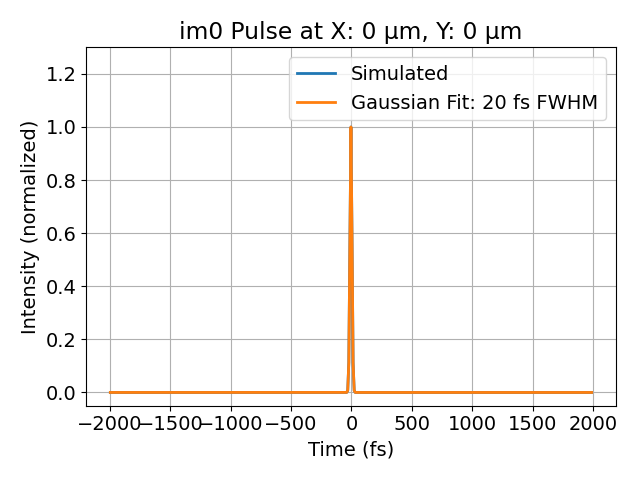

<IPython.core.display.Javascript object>


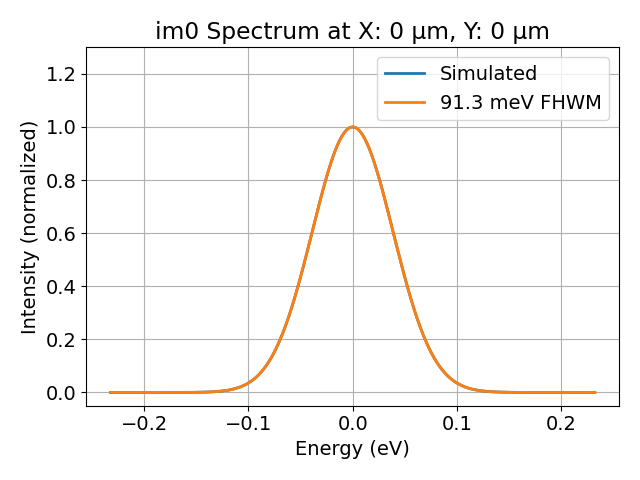

<IPython.core.display.Javascript object>


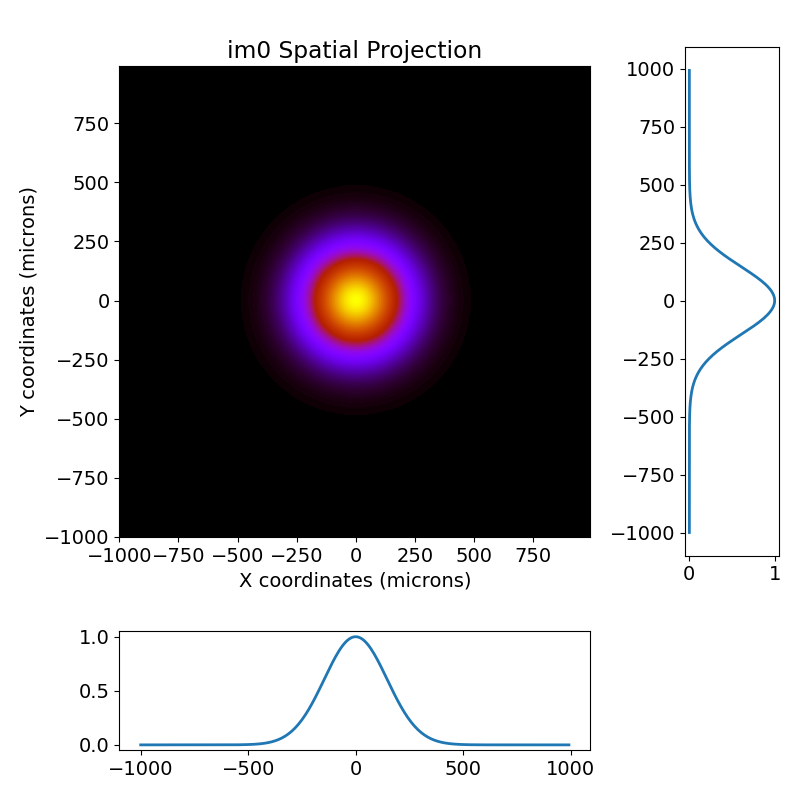

(<matplotlib.axes._subplots.AxesSubplot at 0x1212c31d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120720e50>)

In [29]:
# plot input pulse at beam center
pulse.plot_pulse('im0')
# plot input spectrum at beam center
pulse.plot_spectrum('im0')
# plot input beam spatial projection
pulse.imshow_projection('im0')

### Visualize focus properties

<IPython.core.display.Javascript object>


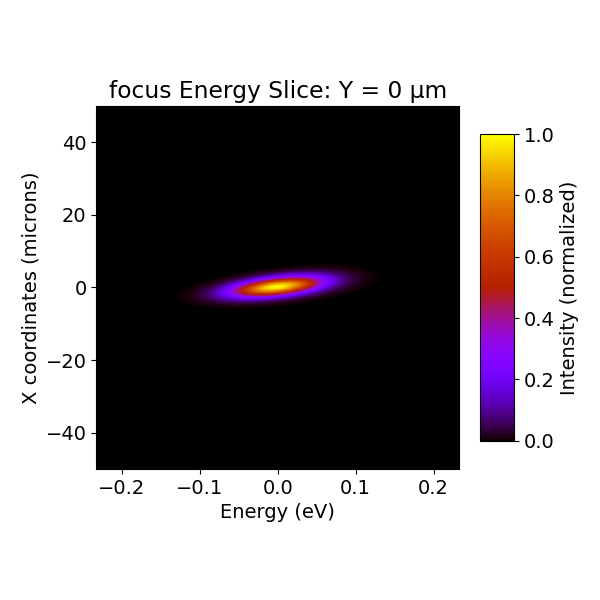

<IPython.core.display.Javascript object>


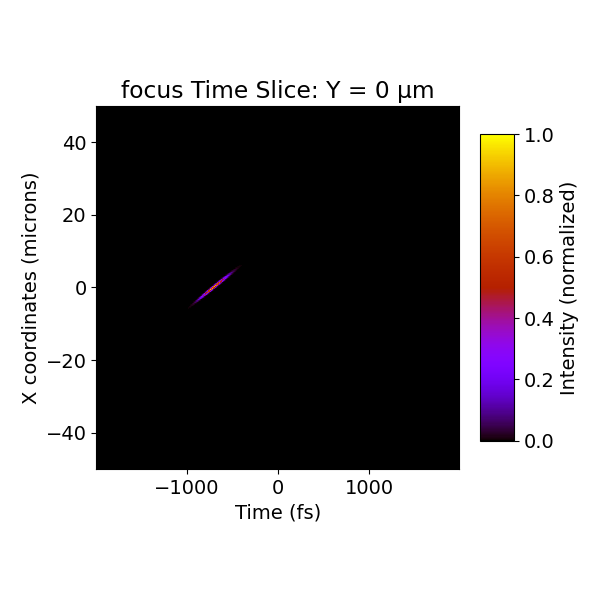

128


<IPython.core.display.Javascript object>


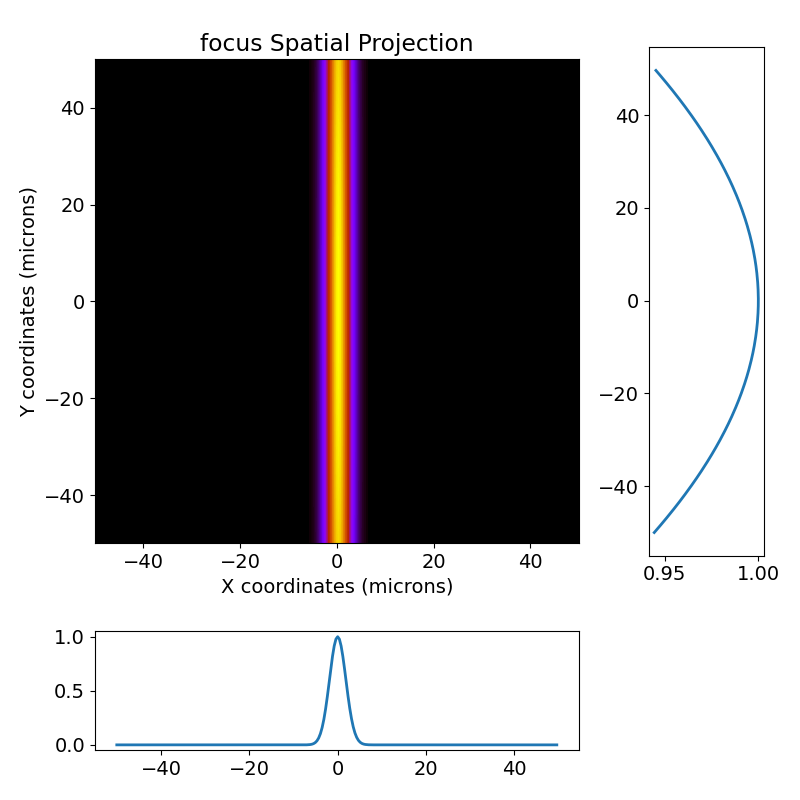

(<matplotlib.axes._subplots.AxesSubplot at 0x121bffd10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121c3b390>)

In [30]:
# plot energy slice of focus
pulse.imshow_energy_slice('focus')
# plot time slice of focus
pulse.imshow_time_slice('focus')
# show spatial projection
pulse.imshow_projection('focus')

### Visualize output

<IPython.core.display.Javascript object>


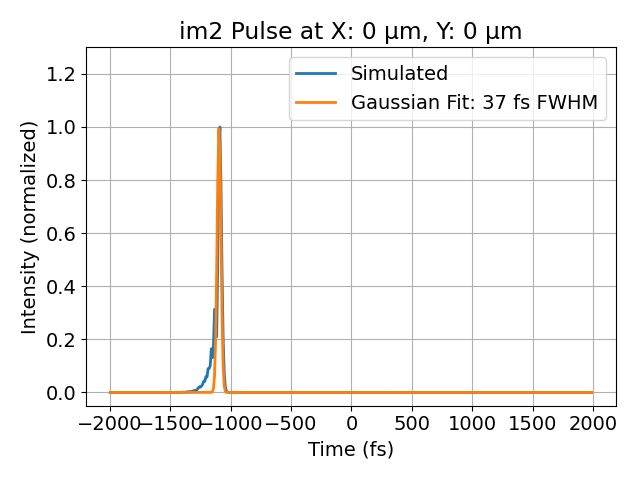

<IPython.core.display.Javascript object>


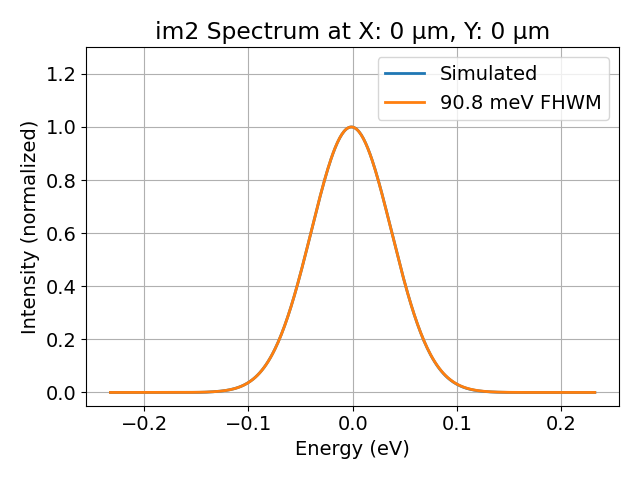

<IPython.core.display.Javascript object>


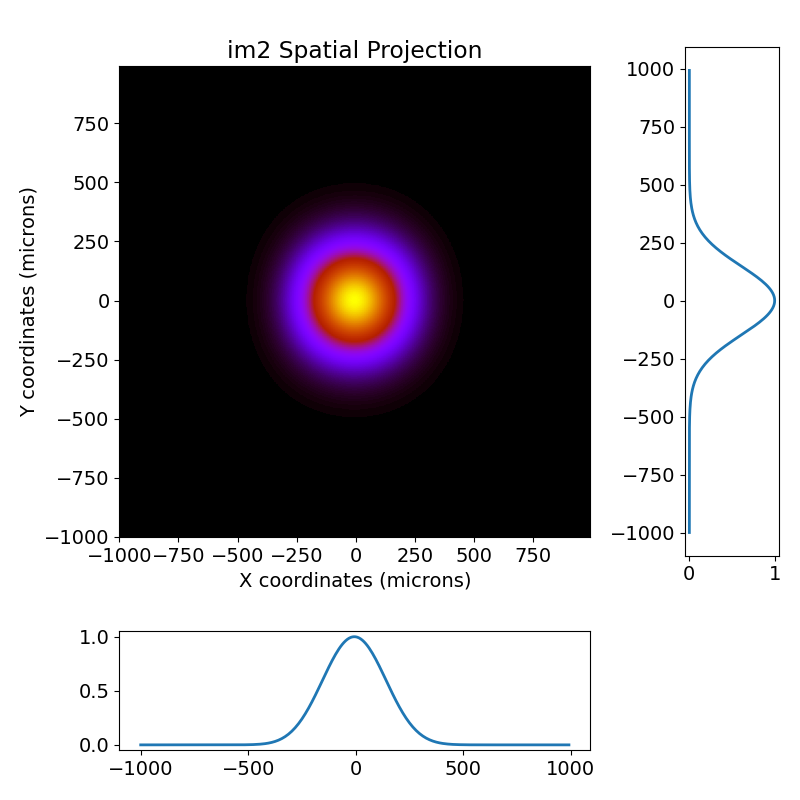

<IPython.core.display.Javascript object>


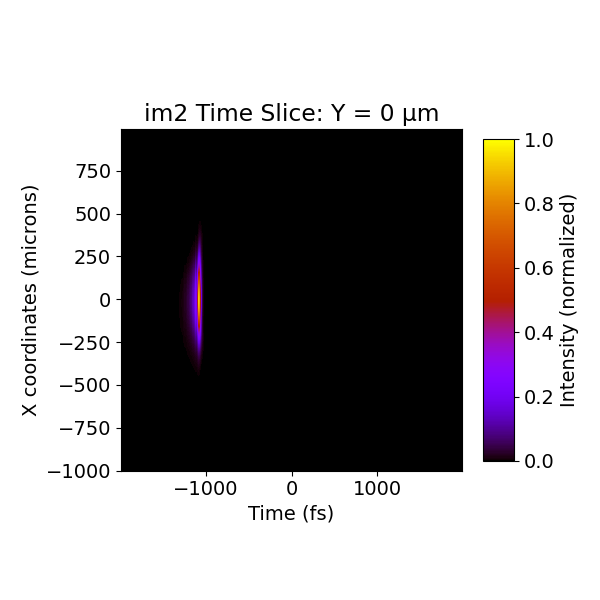

128


<IPython.core.display.Javascript object>


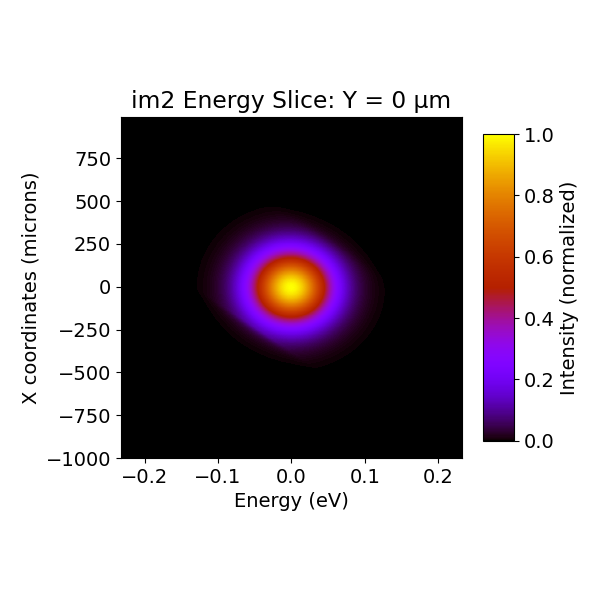

<IPython.core.display.Javascript object>


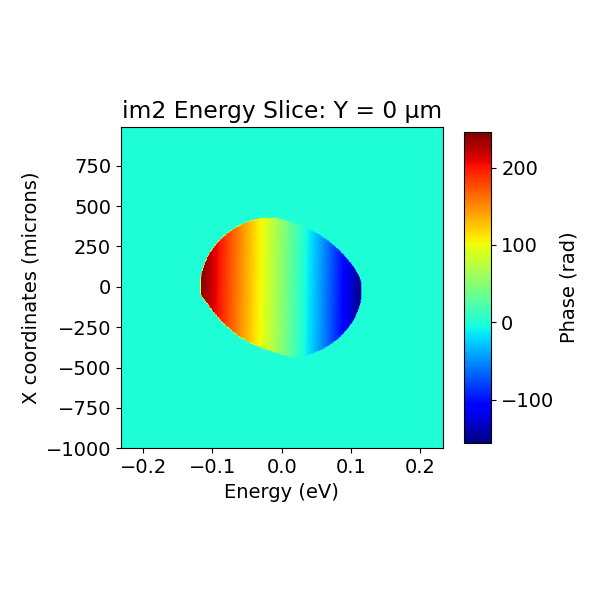

In [37]:
# plot output pulse at beam center
pulse.plot_pulse('im2', shift=0)
# plot output spectraum at beam center
pulse.plot_spectrum('im2')
# show spatial projection of output
pulse.imshow_projection('im2')
# show time slice of output
pulse.imshow_time_slice('im2')
plt.tight_layout()
# show energy slice of output
pulse.imshow_energy_slice('im2')
# show spectral phase slice of output
pulse.imshow_energy_slice('im2', image_type='phase')

In [2]:
lambda0 = 1239.8/9000*1e-9
phase = 80
path = phase*lambda0/2/np.pi

In [3]:
print(path)

1.7539582084029499e-09
